# Recipe Traffic Prediction: A Data-Driven Approach to Optimizing Homepage Engagement

# Executive Summary

## **Objective**
The goal of this project was to develop a robust machine learning solution to help the business identify recipes that drive high website traffic. By accurately predicting which recipes will generate high traffic, the company aims to maximize user engagement and increase subscription rates, while minimizing the risk of recommending unpopular recipes.

## **Approach**
To achieve this, the project followed a systematic process involving data validation, exploratory analysis, feature engineering, model development, and evaluation. Three machine learning models—**Logistic Regression**, **Random Forest**, and a **Stacking Classifier**—were evaluated to identify the best-performing approach.

Key considerations included:
- Ensuring the models predicted high-traffic recipes with **80% accuracy or higher**.
- Developing and testing models on both the **original dataset** and an **engineered dataset** enriched with traffic-based and interaction features.
- Addressing class imbalances, as recipes labeled as "Other" (low traffic) comprised 40% of the data.
- Balancing model precision and recall to avoid both missed opportunities for high-traffic recipes and the inclusion of low-traffic recipes on the homepage.

## **Results**
The Stacking Classifier, combining **Logistic Regression** and **Random Forest** as base models, emerged as the best-performing solution, achieving:
- **F1-Score for High-Traffic Recipes**: 0.81
- **Precision for High-Traffic Recipes**: 0.82
- **Recall for High-Traffic Recipes**: 0.80
- **ROC AUC Score**: 0.83

These results met the project’s primary objective of predicting high-traffic recipes with strong reliability. The Stacking Classifier also improved recall for the "Other" class (0.74), ensuring better identification of low-traffic recipes compared to individual models.

While the engineered dataset contributed valuable insights (e.g., category-based traffic ratios), concerns about overfitting and reliance on dominant features led to prioritizing models trained on the **original dataset** for production.

## **Recommendations**
1. **Deploy the Stacking Classifier**:
   - This model should be implemented as the primary tool for recommending recipes on the homepage. Its robust performance ensures a balance between precision and recall for both high- and low-traffic recipes.

2. **Monitor and Evaluate Performance**:
   - Use **Recall for High-Traffic Recipes** as the primary metric, with thresholds of 70%-80% for good performance and >80% for optimal performance.
   - Track user engagement metrics, such as clicks and subscriptions, to validate predictions.

3. **Address Class Imbalance**:
   - Consider advanced techniques like cost-sensitive learning or oversampling to further improve recall for the "Other" class.

4. **Periodic Model Retraining**:
   - Regularly update the model using newly collected data, particularly during seasonal or holiday periods, to capture shifting trends and ensure ongoing accuracy.

5. **Expand Dataset**:
   - Incorporate additional recipes and user behavior data to improve model generalizability and robustness.

6. **Leverage Engineered Features for Insights**:
   - While the engineered dataset raised overfitting concerns, features like `high_traffic_ratio_by_cat` provided actionable insights into category popularity. These insights can inform broader marketing strategies beyond recipe recommendations.

## **Key Impact**
Deploying the Stacking Classifier has the potential to significantly improve homepage traffic predictions. By moving from the current manual selection process (60% accuracy) to a data-driven approach, the business can expect:
- A **10%-20% increase in prediction accuracy** during the early phases of deployment.
- Enhanced user engagement and subscription rates due to more accurate recommendations.
- Data-driven insights that empower strategic decision-making across marketing and product initiatives.

With these recommendations, the company can effectively align its homepage recipe selection process with its strategic goal of maximizing website traffic and driving subscriptions.

# Introduction

Recipes play a pivotal role in attracting visitors to Tasty Byte's website, with popular recipes driving up to 40% more traffic and increasing subscriptions. However, selecting recipes likely to generate high user engagement has traditionally relied on subjective judgment.

This project aims to address this challenge by leveraging data-driven machine learning models to predict which recipes are likely to experience high traffic. By accurately identifying high-traffic recipes, the company can enhance user satisfaction, optimize homepage content, and ultimately drive more subscriptions.

The following report outlines the data validation, analysis, feature engineering, and modeling steps taken to achieve this goal, as well as recommendations for deploying and monitoring the selected model to maximize business impact.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Read in the data 
recipes_raw = pd.read_csv('recipe_site_traffic_2212.csv')
print('Raw Data Info: \n')
recipes_raw.info()

# Check for percentage of missing values
recipes_raw.isnull().sum()/len(recipes_raw)

# ------------------------------------ #
# Data Validation                      #
# ------------------------------------ #

# Check recipe is a unique identifier 
recipes_raw['recipe'].nunique()

# Confirm that categories are correct 
recipes_raw['category'].unique()

# Replace incorrect categories
recipes_raw['category'] = recipes_raw['category'].replace('Chicken Breast', 'Chicken')

# Adjust servings column to display values as intended
recipes_raw['servings'] = recipes_raw['servings'].str.replace(' as a snack','', regex=False).astype('int')

# Evaluate missing values per category
df_missing_perc = recipes_raw.groupby('category').agg(lambda cat: cat.isnull().mean())[['calories', 'carbohydrate', 'sugar', 'protein']]

# Assumption: Missing values on 'high_traffic' column represent instances where the recipe is not high traffic
# Create 'high_traffic_bool' column to display Boolean Values for High_traffic
recipes_raw['high_traffic_bool'] = recipes_raw['high_traffic'].apply(lambda x: False if pd.isnull(x) else True)

# Adjust 'high_traffic' column to display 'Other' for NaN values 
recipes_raw['high_traffic'] = recipes_raw['high_traffic'].fillna('Other')

# Drop rows with null values 
recipes_raw.dropna(inplace=True)

# Make sure columns have appropriate categories 
recipes_raw['category'] = recipes_raw['category'].astype('category')

# Confirm there are no missing values and that column types have the appropriate categories
print('------------------\n','Info after Validation and Cleaning \n')
print(recipes_raw.info())

# Drop Recipe Column 
recipes_raw = recipes_raw.drop('recipe', axis=1)

# Save file 
recipes_raw.to_pickle('recipes_site_traffic_clean.pkl')

Raw Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
------------------
 Info after Validation and Cleaning 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   recipe             895 non-null    int64   
 1   calories           895 non-null    float64 
 2   carbohydrate       895 n

# **Data Validation**

This project utilized a dataset containing recipe information, including both numerical and categorical features, as well as a binary target variable, `high_traffic`. The following validation and cleaning steps were conducted to ensure the data was accurate, consistent, and ready for analysis.

## **Validation and Adjustments by Column**

**1. `recipe`**
- **Description**: A unique numeric identifier for each recipe.
- **Validation**: 
  - No missing or duplicate values were detected. 
- **Adjustment**: 
  - None required.

**2. Nutritional Features: `calories`, `carbohydrate`, `sugar`, `protein`**
- **Description**: Numerical features providing nutritional information for each recipe.
- **Validation**: 
  - Missing values were detected in some columns. 
- **Adjustment**: 
  - Rows with missing values were removed, given the small proportion of missing data, to maintain data integrity and avoid potential biases from imputation.

**3. `category`**
- **Description**: A categorical variable representing one of ten recipe groupings:
  - `Lunch/Snacks`, `Beverages`, `Potato`, `Vegetable`, `Meat`, `Chicken`, `Pork`, `Dessert`, `Breakfast`, and `One Dish Meal`.
- **Validation**: 
  - Inconsistent labeling was identified. For instance:
    - `Chicken Breast` was incorrectly categorized instead of being grouped under the broader category `Chicken`.
- **Adjustment**: 
  - Labels like `Chicken Breast` were corrected to their general categories.
  - The final categories were verified to align with the ten intended groupings.

**4. `servings`**
- **Description**: A numerical feature indicating the number of servings for each recipe.
- **Validation**: 
  - Inconsistent entries were detected, such as textual formats (e.g., "4 as a snack").
- **Adjustment**: 
  - Entries were cleaned and converted into a uniform numeric format to ensure compatibility with downstream transformations.

**5. `high_traffic`**
- **Description**: A binary categorical variable indicating whether a recipe experienced high traffic (`High`).
- **Validation**: 
  - Missing values were found for all entries that did not experience `High` traffic.
- **Adjustment**: 
  - Missing values were encoded as `Other` for clarity.
  - A new column, `high_traffic_bool`, was created to facilitate numerical operations:
    - Recipes with `High` traffic were labeled as `True`.
    - Recipes with `Other` traffic were labeled as `False`.

## **Post-Validation Summary**

Following cleaning and validation, the dataset contained **895 entries**, with each record representing a recipe characterized by consistent and well-defined features. These adjustments ensured the data was robust and ready for subsequent analysis and modeling.

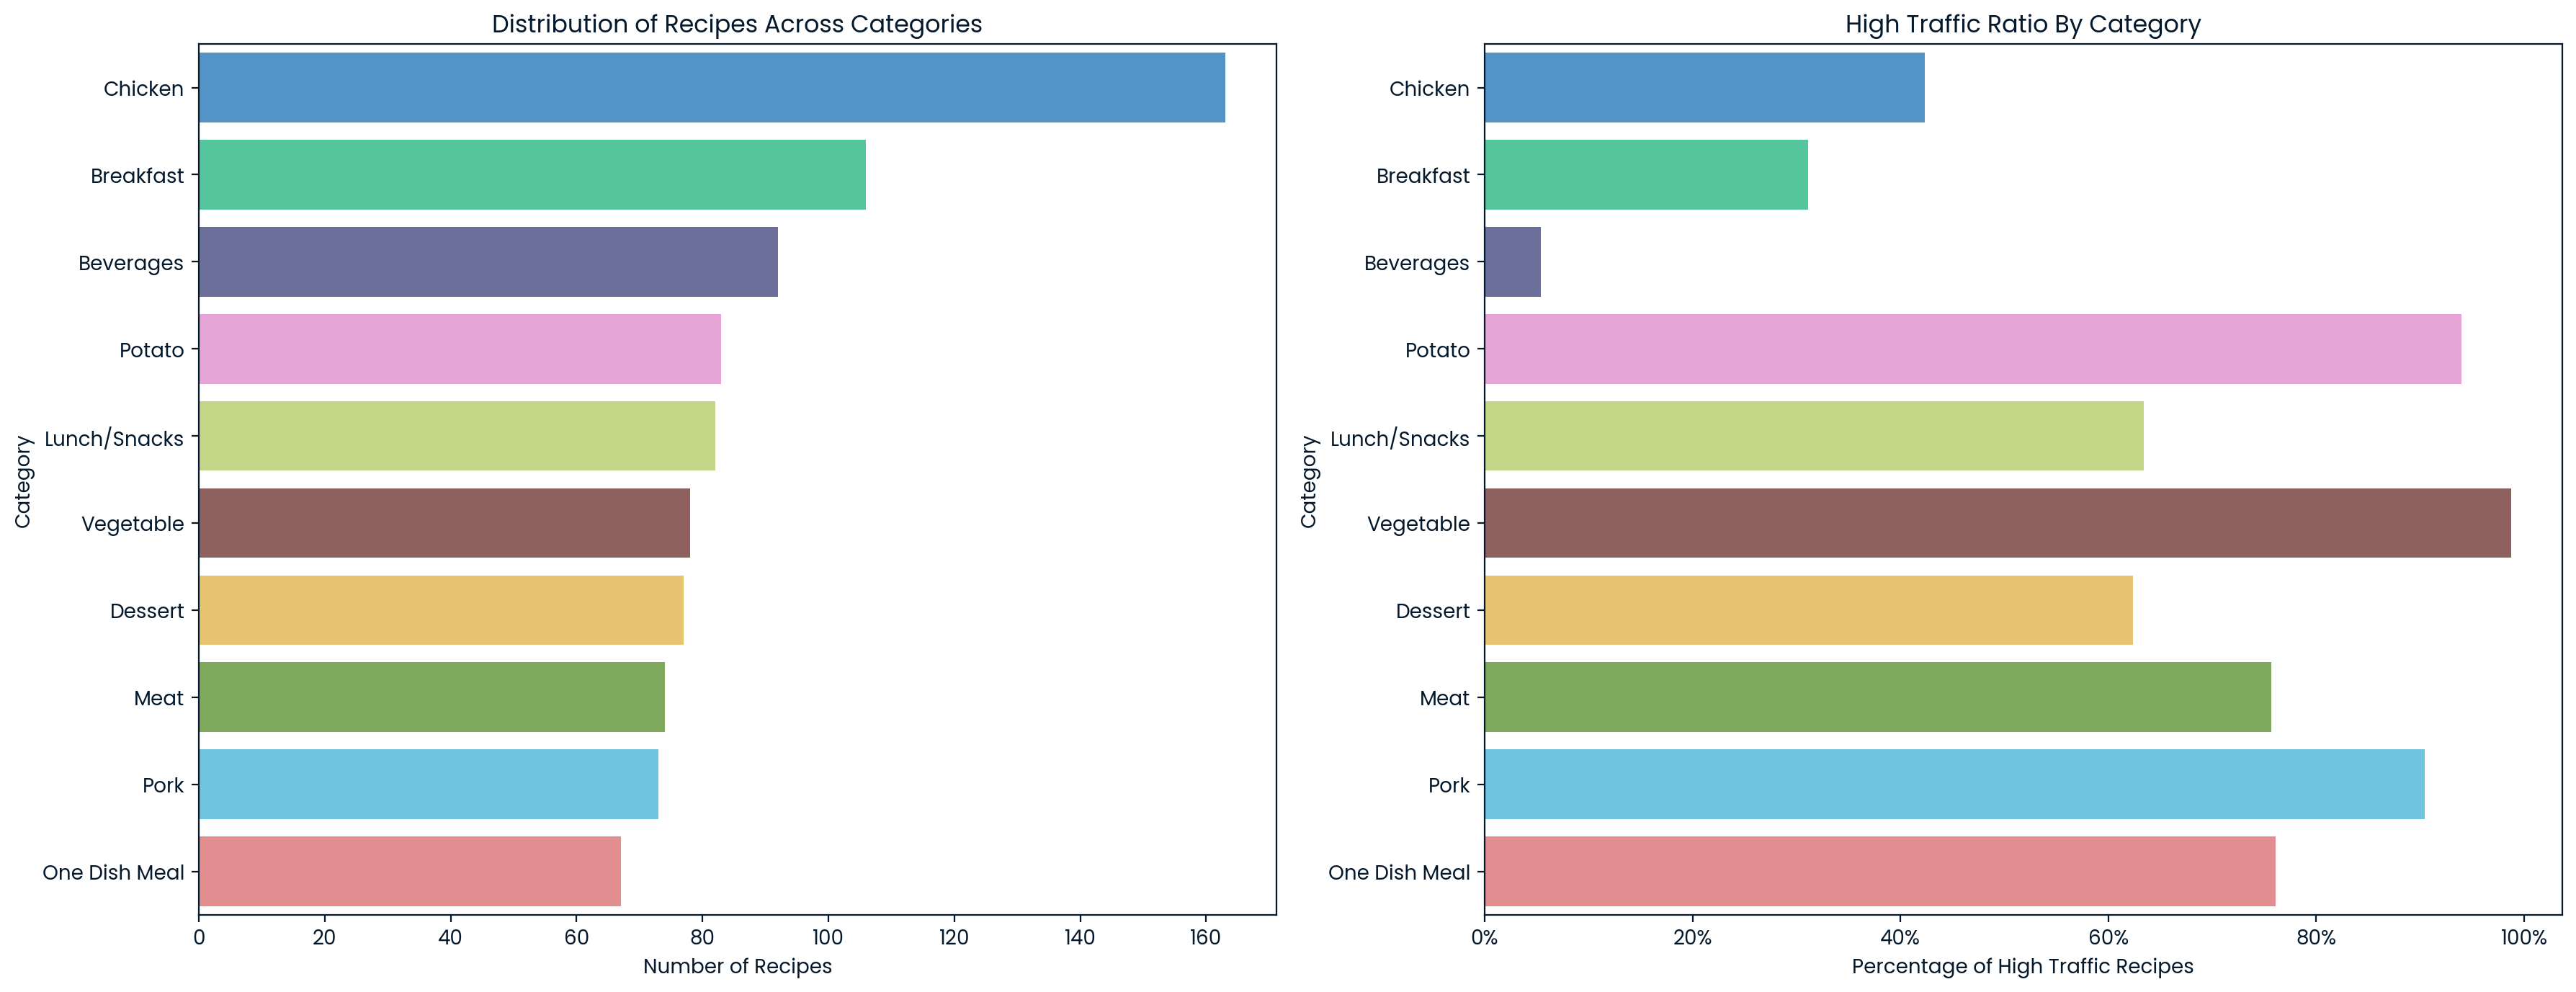

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Read in the data 
recipes = pd.read_pickle('recipes_site_traffic_clean.pkl')
nutritional_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

# ----------------------------- # 
# Exploratory Data Analysis     # 
# ----------------------------- # 

recipes['high_traffic'].value_counts()

# Distribution of Categories
traffic_by_cat = recipes.groupby('category', observed=False)['high_traffic_bool'].value_counts().unstack()
traffic_by_cat['total_recipe_count'] = recipes.groupby('category', observed=False).size()
traffic_by_cat['high_traffic_ratio_by_cat'] = recipes.groupby('category', observed=False)['high_traffic_bool'].sum() / recipes.groupby('category', observed=False).size()
traffic_by_cat.to_csv('tables/Traffic_by_cat_summary.csv')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.barplot( # Barplot 1: Distribution of Recipes Across Categories
    data=traffic_by_cat.sort_values(by='total_recipe_count', ascending=False), 
    x='total_recipe_count',
    y='category',
    order=traffic_by_cat.sort_values(by='total_recipe_count', ascending=False).index,
    ax=axes[0], # Left Plot
    hue='category',
    legend=False 
)
axes[0].set_title('Distribution of Recipes Across Categories')
axes[0].set_xlabel('Number of Recipes')
axes[0].set_ylabel('Category')


# Format x-axis of the second plot to show percentage
def percent(x, pos):
    return f'{x*100:.0f}%'

sns.barplot( # Barplot 2: High Traffic Ratio by Category
    data=traffic_by_cat.sort_values(by='total_recipe_count', ascending=False), 
    x='high_traffic_ratio_by_cat',
    y='category',
    order=traffic_by_cat.sort_values(by='total_recipe_count', ascending=False).index,
    ax=axes[1], # Right Plot
    hue='category',
    legend=False 
)
axes[1].set_title('High Traffic Ratio By Category')
axes[1].set_xlabel('Percentage of High Traffic Recipes')
axes[1].set_ylabel('Category')
axes[1].xaxis.set_major_formatter(FuncFormatter(percent))
plt.tight_layout()
plt.savefig('figures/category_summary.png', bbox_inches='tight')

'Calories' column does not contain any values with 0
'Carbohydrate' column does not contain any values with 0
'Sugar' column does not contain any values with 0
'Protein' contains values equal to 0
-----------------------

'Calories' contains only positive values
'Carbohydrate' contains only positive values
'Sugar' contains only positive values
'Protein' contains only positive values
-----------------------

Optimal λ for 'Calories': 0.2426408568503281
Optimal λ for 'Carbohydrate': 0.09579937112050636
Optimal λ for 'Sugar': -0.2041830421569333
Optimal λ for 'Protein': 0.005370216621261132
<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   calories             895 non-null    float64 
 1   carbohydrate         895 non-null    float64 
 2   sugar                895 non-null    float64 
 3   protein              895 non-null    flo

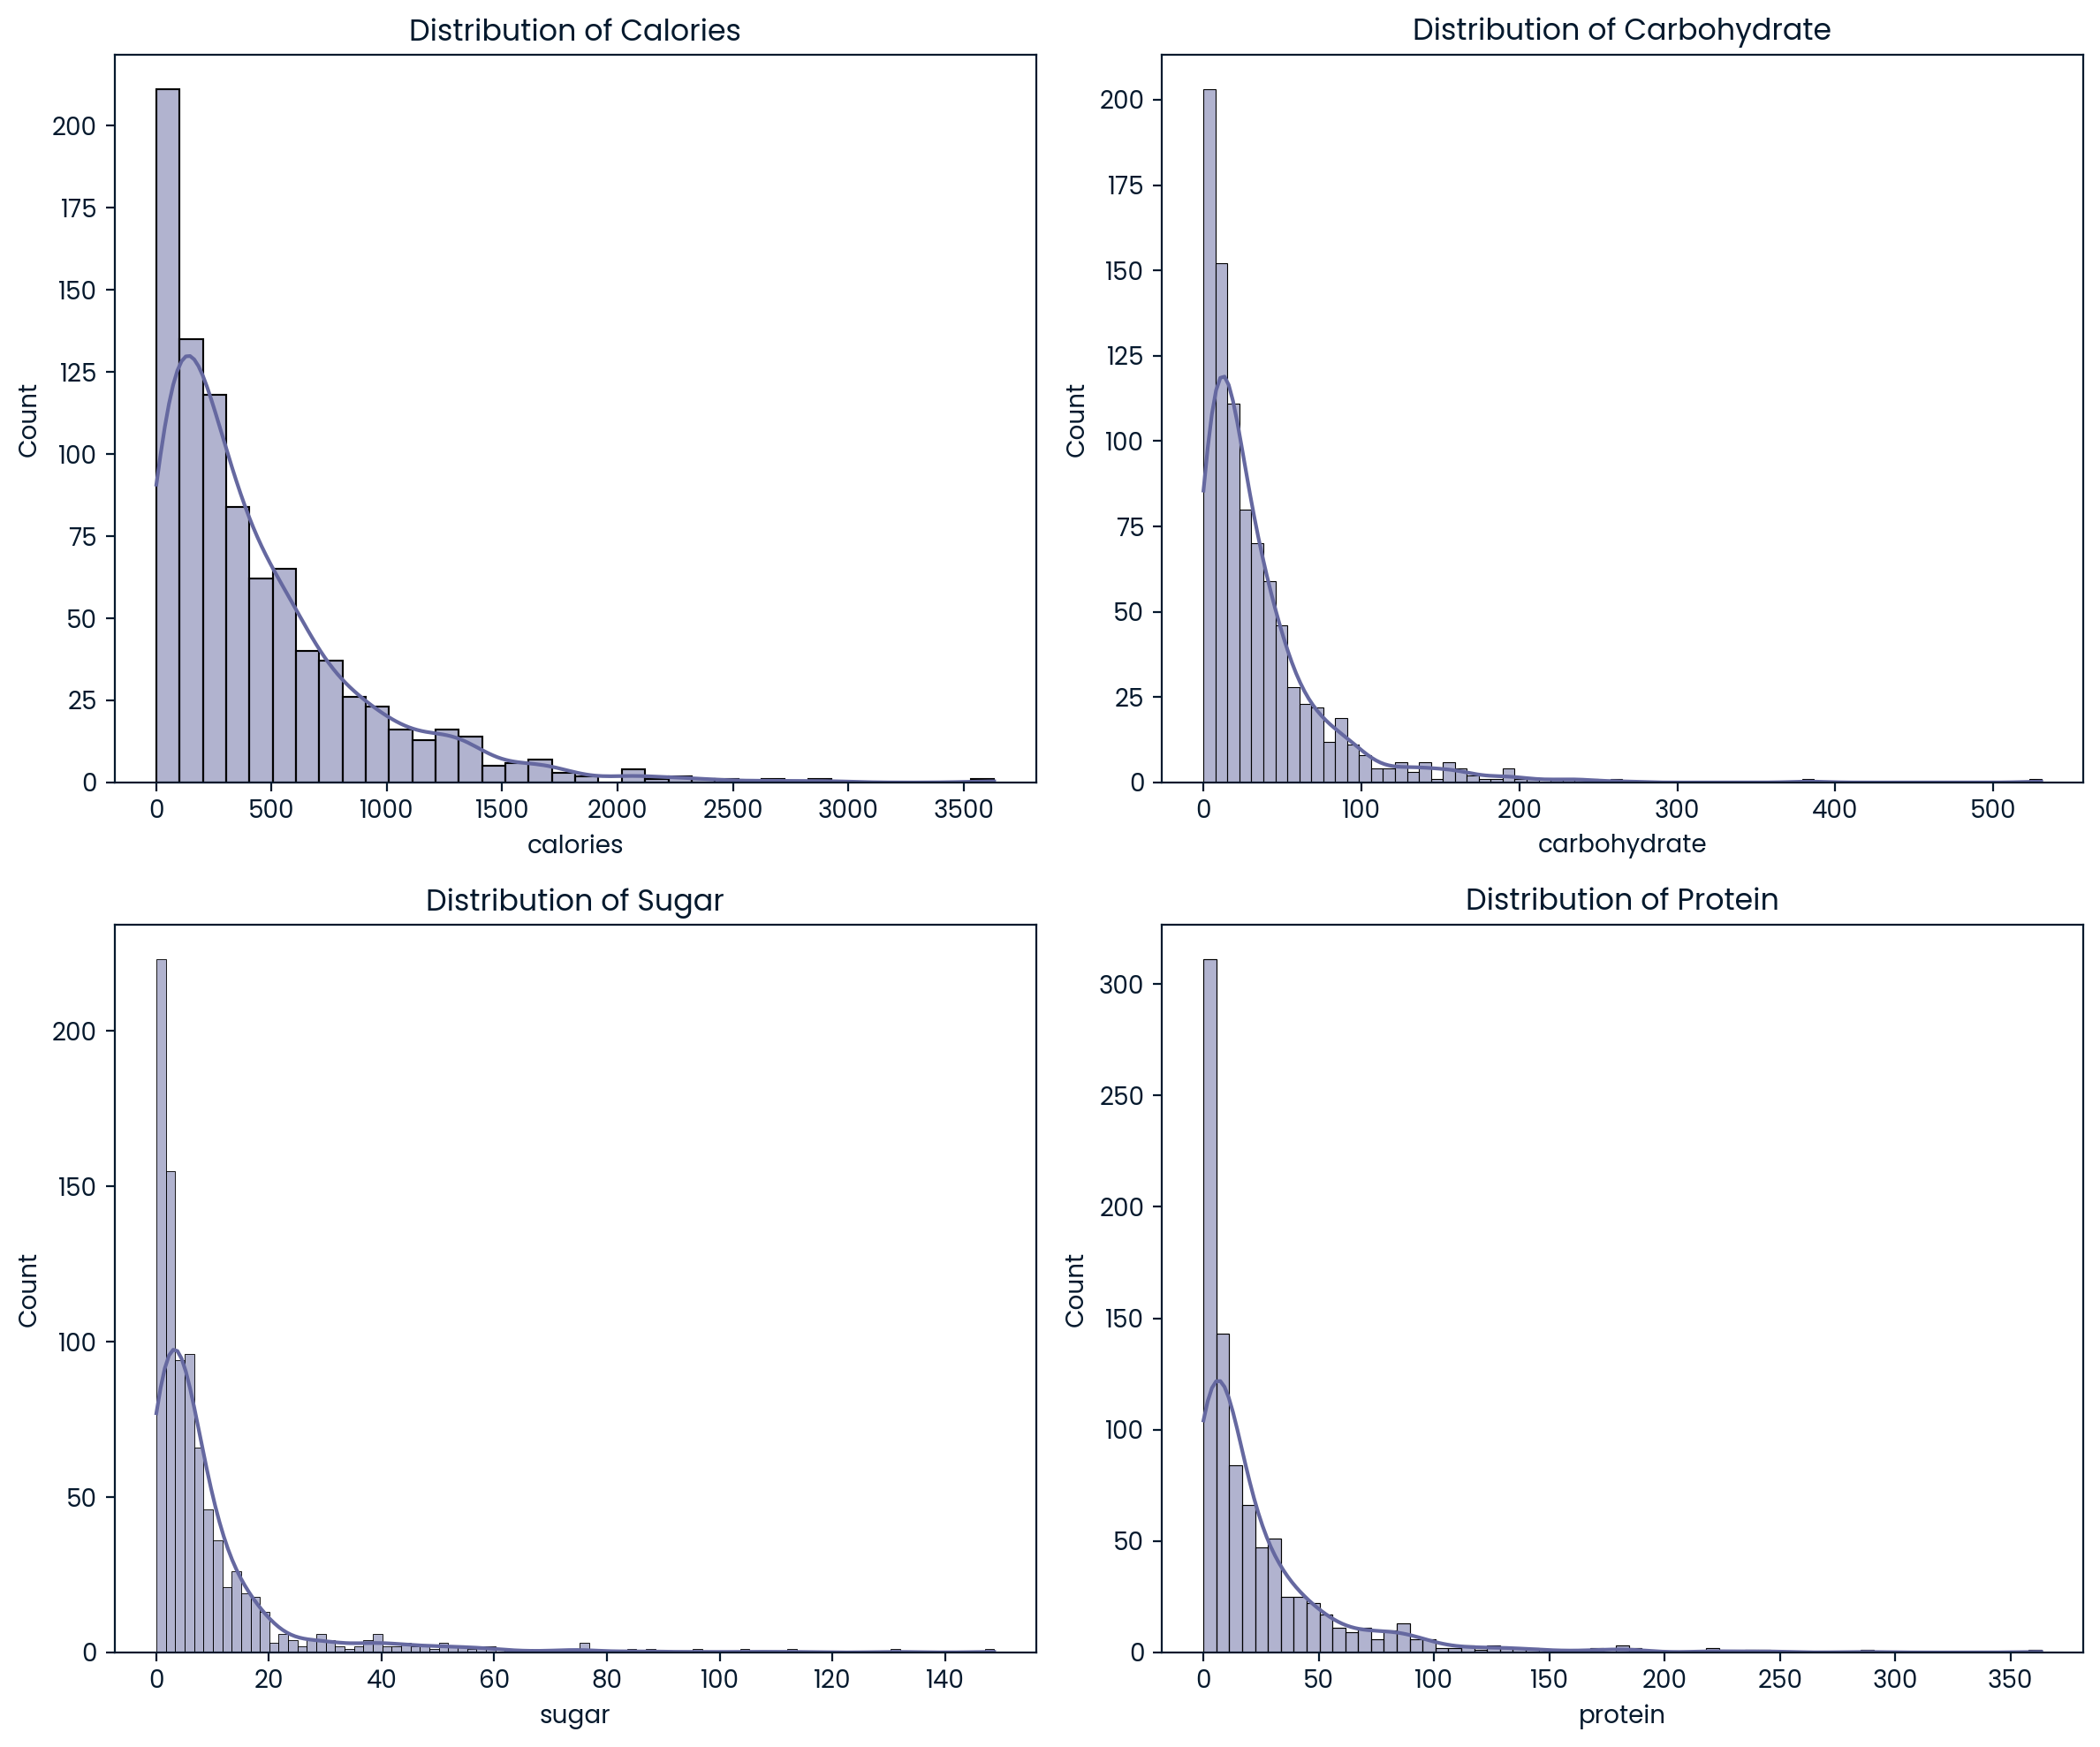

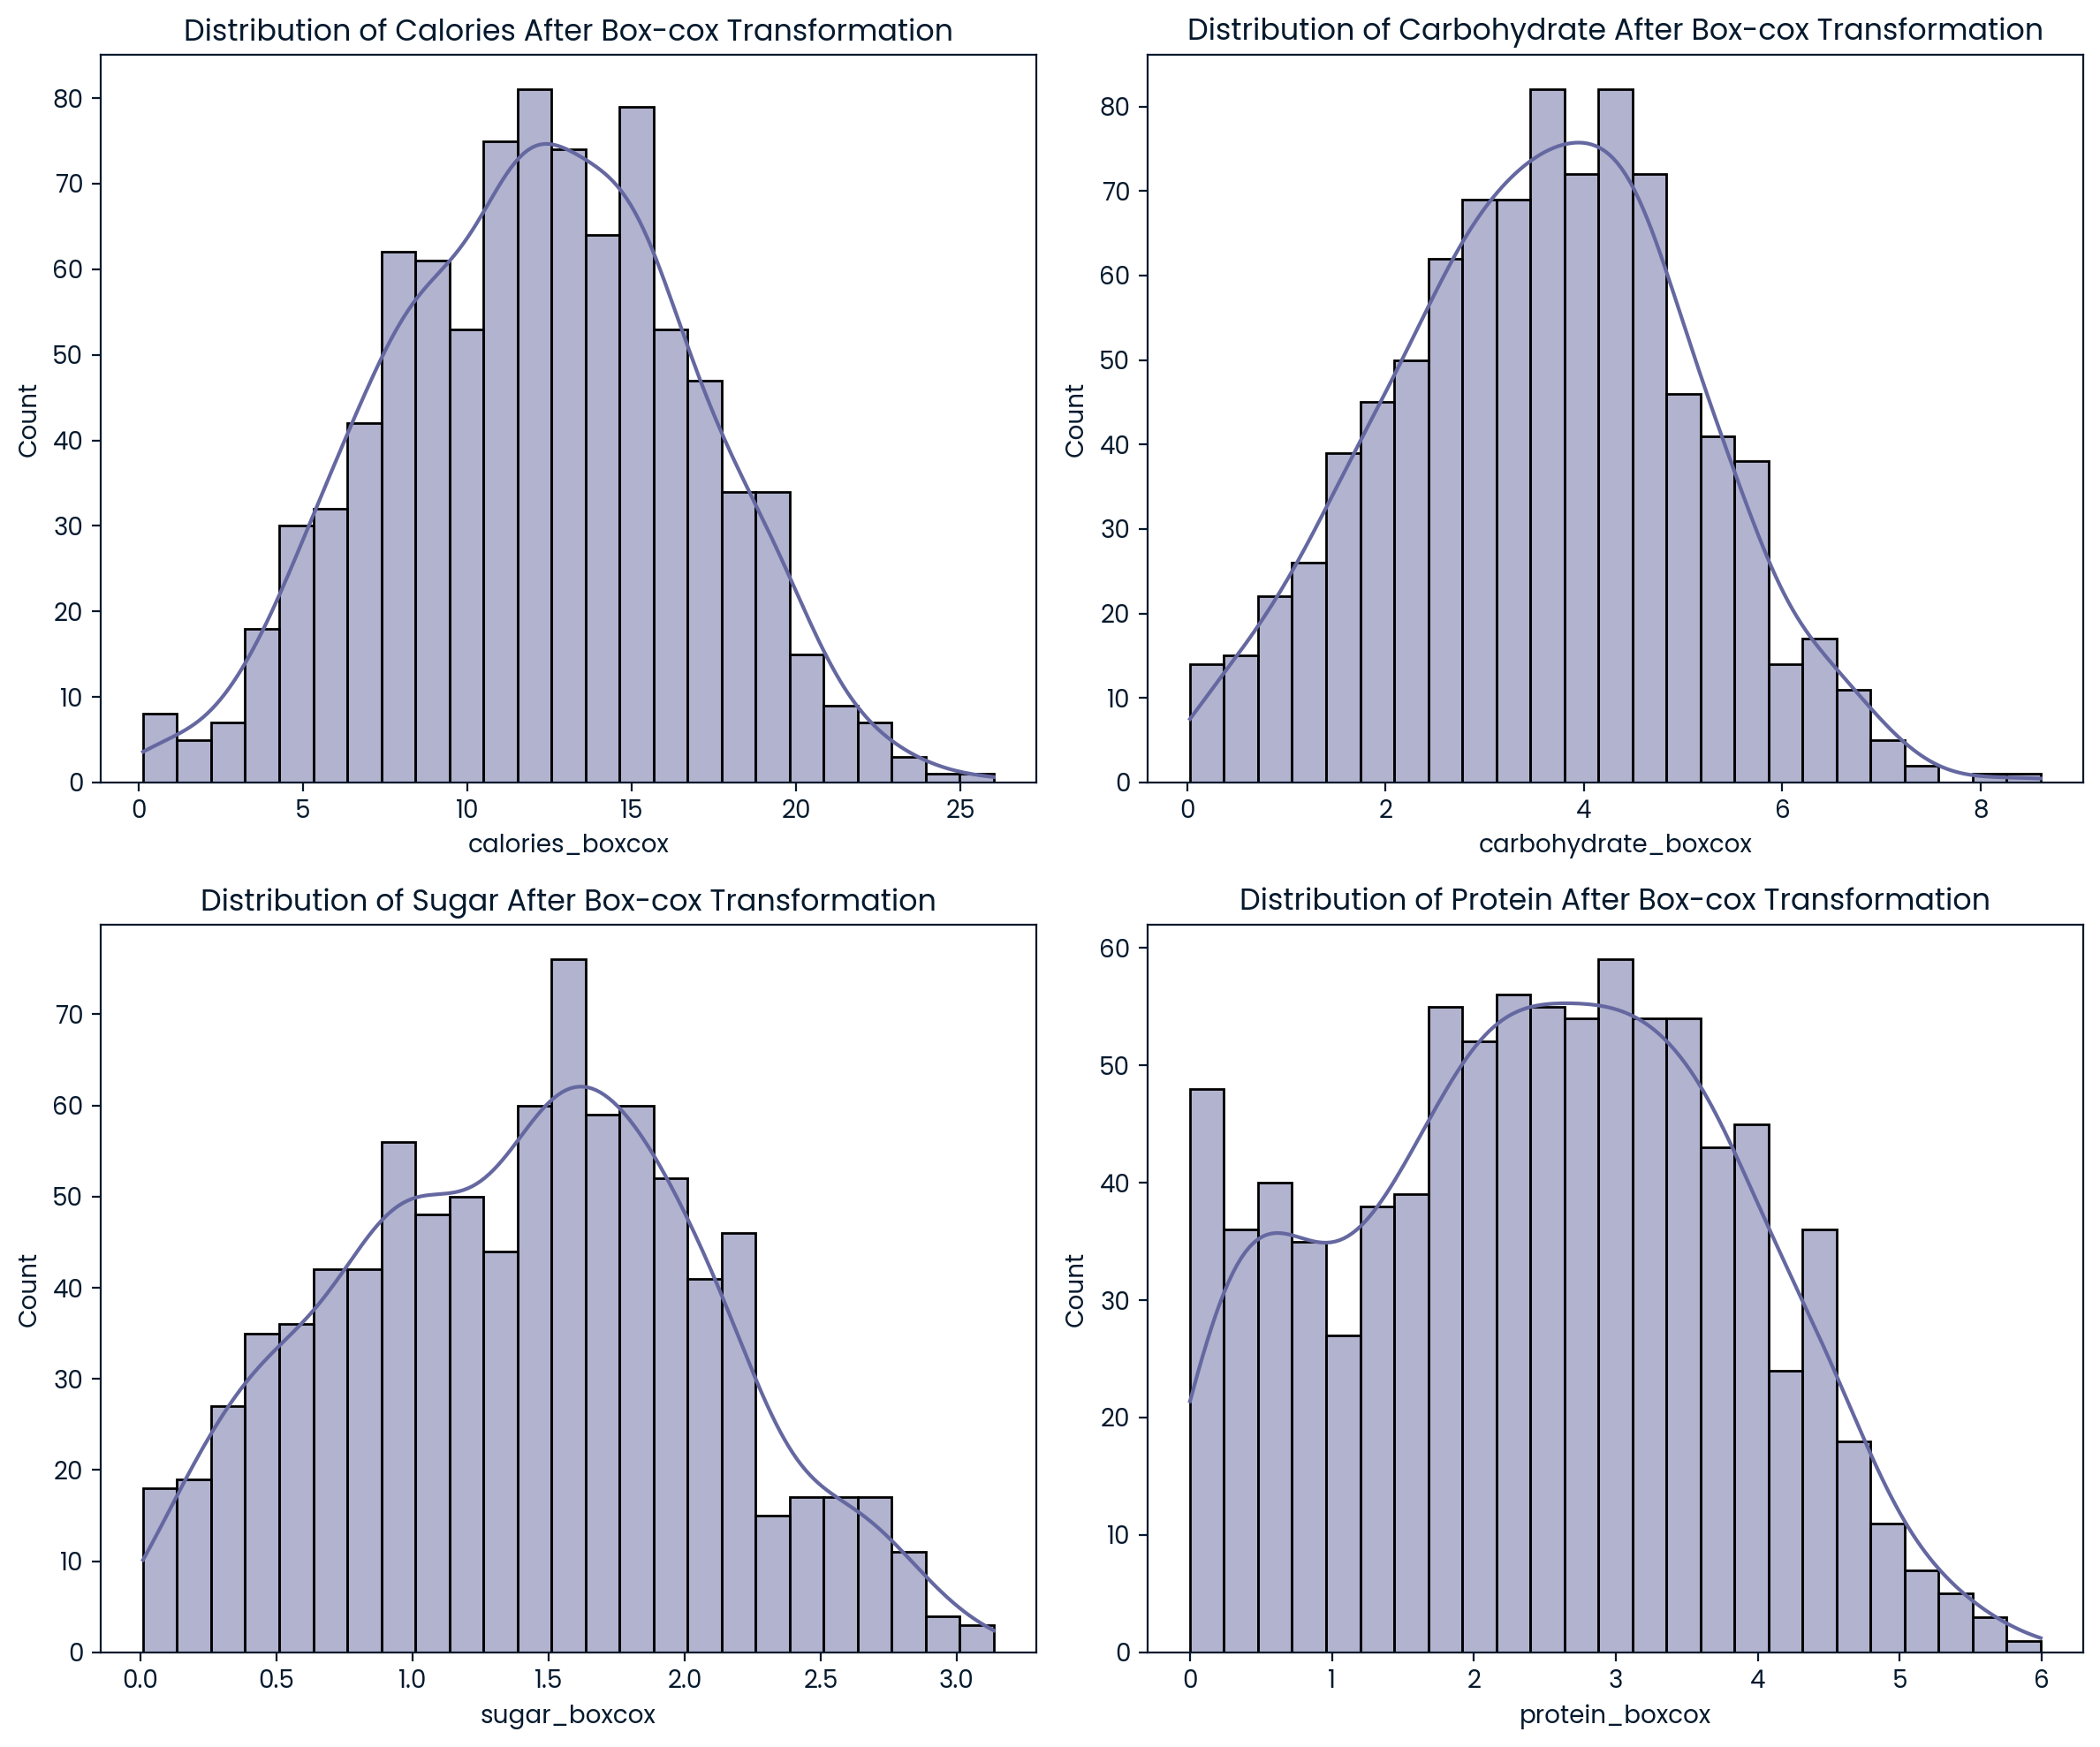

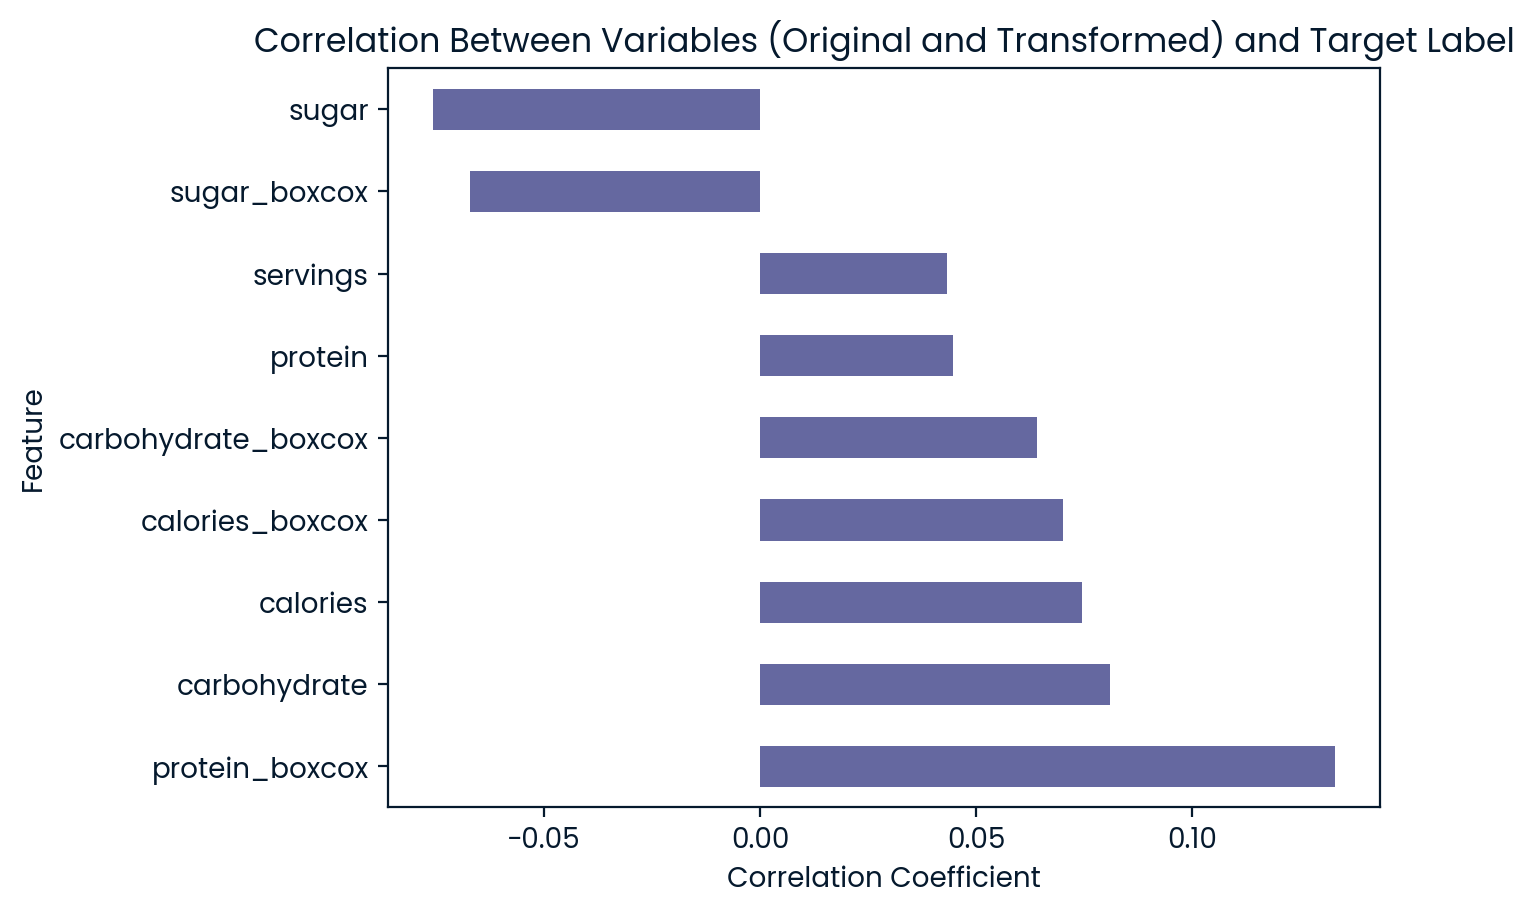

In [3]:
# ----------------------------- # 
# Box-cox Transformation        # 
# ----------------------------- # 
from scipy.stats import boxcox

# Plot distributions for nutritional features
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
for i, column in enumerate(nutritional_columns):
    row = i // 2  
    col = i % 2   
    sns.histplot(data=recipes, x=column, kde=True, ax=axes[row, col])  
    axes[row, col].set_title(f'Distribution of {column.title()}')  
plt.tight_layout() 
plt.savefig('figures/nutritional_features_distributions.png', bbox_inches='tight')

# Check if there are values = 0 in the nutritional columns: 
for col in nutritional_columns: 
    if len(recipes[recipes[col]==0] == 0) == 0: 
        print(f"'{col.title()}' column does not contain any values with 0")
    else: 
        print(f"'{col.title()}' contains values equal to 0") 
        
print('-----------------------\n')        
        
# Check for non-negative values
for col in nutritional_columns: 
    if len(recipes[recipes[col] < 0]) == 0: 
        print(f"'{col.title()}' contains only positive values")
    else: 
        print(f"'{col.title()}' contains negative values")       
        
print('-----------------------\n')              

# Apply Box-Cox transformation to each column
for col in nutritional_columns:
    recipes[col] = recipes[col] + 1  # Add 1  to handle zeros
    
    # Apply Box-Cox transformation
    recipes[f'{col}_boxcox'], lambda_val = boxcox(recipes[col])
    
    # Print lambda for each column
    print(f"Optimal λ for '{col.title()}': {lambda_val}") 
    
# Plot distributions for nutritional features (after box-cox transformation)
nutritional_columns_boxcox = ['calories_boxcox','carbohydrate_boxcox', 'sugar_boxcox', 'protein_boxcox']      

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
for i, column in enumerate(nutritional_columns_boxcox):
    row = i // 2  
    col = i % 2   
    sns.histplot(data=recipes, x=column, kde=True, ax=axes[row, col], bins=25)  
    axes[row, col].set_title(f'Distribution of {column.replace("_boxcox", "").title()} After Box-cox Transformation')  
plt.tight_layout() 
plt.savefig('figures/BC_nutritional_features_distributions.png', bbox_inches='tight')

# Correlation between old and new variables
correlation = pd.DataFrame(recipes.corr(numeric_only=True)['high_traffic_bool']).sort_values(by='high_traffic_bool', ascending=False).drop('high_traffic_bool', axis=0)
correlation.plot(kind='barh')
plt.title('Correlation Between Variables (Original and Transformed) and Target Label')
plt.ylabel('Feature')
plt.xlabel('Correlation Coefficient')
plt.legend().remove()
plt.savefig('figures/correlation_barplot.png', bbox_inches='tight')

# Save Dataset 
recipes.to_pickle('recipes_box_cox.pkl')
recipes.info()

# **Exploratory Data Analysis**

The dataset was analyzed to understand the relationships between features and the target variable (`high_traffic`). This analysis aimed to uncover patterns and distributions that could inform the subsequent feature engineering and modeling processes.

## **Exploring Recipe Categories**

Before examining feature relationships, the distribution of the `high_traffic` target variable was explored. The dataset includes:
- **535 recipes labeled as 'high' traffic**, representing 59.8% of entries.
- **360 recipes categorized as 'other' traffic**, comprising 40.2%.

The figure below displays:
1. The distribution of recipes across categories.
2. The percentage of high-traffic recipes within each category.

![Category Plots](figures/category_summary.png)

Key Observations:
- Categories like `Chicken`, `Breakfast`, and `Beverages` represent approximately 40% of the dataset but have lower proportions of high-traffic recipes (42%, 31%, and 5%, respectively).
- Categories such as `Vegetable`, `Potato`, and `Pork` show significantly higher proportions of high-traffic recipes (nearly 100% for `Vegetable` and 94% for `Pork`).

These findings underscore the importance of recipe categories in predicting traffic levels. The disparities in high-traffic proportions suggest that category-level features, such as the ratio of high-traffic recipes per category, could enhance prediction accuracy.

## **Inspecting Nutritional Features**

Four key nutritional features—`calories`, `carbohydrate`, `sugar`, and `protein`—were analyzed for their potential predictive value. Initial visualizations revealed significant skewness in these distributions, indicating the presence of outliers and suggesting the need for normalization.

![Nutritional Features Distribution](figures/nutritional_features_distributions.png)

## **Addressing Skewness: Box-Cox Transformation**
A **Box-Cox transformation** was applied to normalize the skewed nutritional features. Before applying the transformation:
1. **Zero Values Check**: 
   - Zero values were identified in the `protein` column. A constant value of `1` was added to all nutritional columns to ensure positivity.
2. **Negative Values Check**: 
   - All columns were verified to contain only positive values.

Post-transformation, new columns (`calories_boxcox`, `carbohydrate_boxcox`, `sugar_boxcox`, `protein_boxcox`) were created. The optimal lambda (λ) values for each feature were recorded:

| **Feature**       | **Optimal Lambda Value (λ)** |
|-------------------|------------------------------|
| Calories          | 0.2426                       |
| Carbohydrate      | 0.0958                       |
| Sugar             | -0.2042                      |
| Protein           | 0.0054                       |

### **Evaluating the Transformation**
The transformed distributions showed improved symmetry, indicating successful normalization:

![Box-Cox Nutritional Features Distribution](figures/BC_nutritional_features_distributions.png)

## **Correlation Analysis**

The relationship between features and the target variable was examined. The bar plot below illustrates the correlations:

![Correlation Barplot](figures/correlation_barplot.png)

Key Findings:
- Correlations were generally weak, suggesting potential non-linear relationships between features and the target variable.
- This emphasizes the need for advanced feature engineering and the application of non-linear models.

## **Conclusion and Transition to Feature Engineering**

The exploratory analysis revealed critical insights:
1. **Recipe Categories**: Category-level features significantly impact traffic levels, with disparities in high-traffic proportions across categories.
2. **Nutritional Features**: Skewness was successfully addressed using Box-Cox transformations, making the data more suitable for machine learning.
3. **Weak Correlations**: The observed weak correlations highlight the importance of feature engineering to uncover latent patterns.

The next phase will focus on feature engineering to create meaningful features and capture non-linear relationships, enhancing the predictive power of the models.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   calories             895 non-null    float64 
 1   carbohydrate         895 non-null    float64 
 2   sugar                895 non-null    float64 
 3   protein              895 non-null    float64 
 4   category             895 non-null    category
 5   servings             895 non-null    int64   
 6   high_traffic         895 non-null    object  
 7   high_traffic_bool    895 non-null    bool    
 8   calories_boxcox      895 non-null    float64 
 9   carbohydrate_boxcox  895 non-null    float64 
 10  sugar_boxcox         895 non-null    float64 
 11  protein_boxcox       895 non-null    float64 
dtypes: bool(1), category(1), float64(8), int64(1), object(1)
memory usage: 78.7+ KB


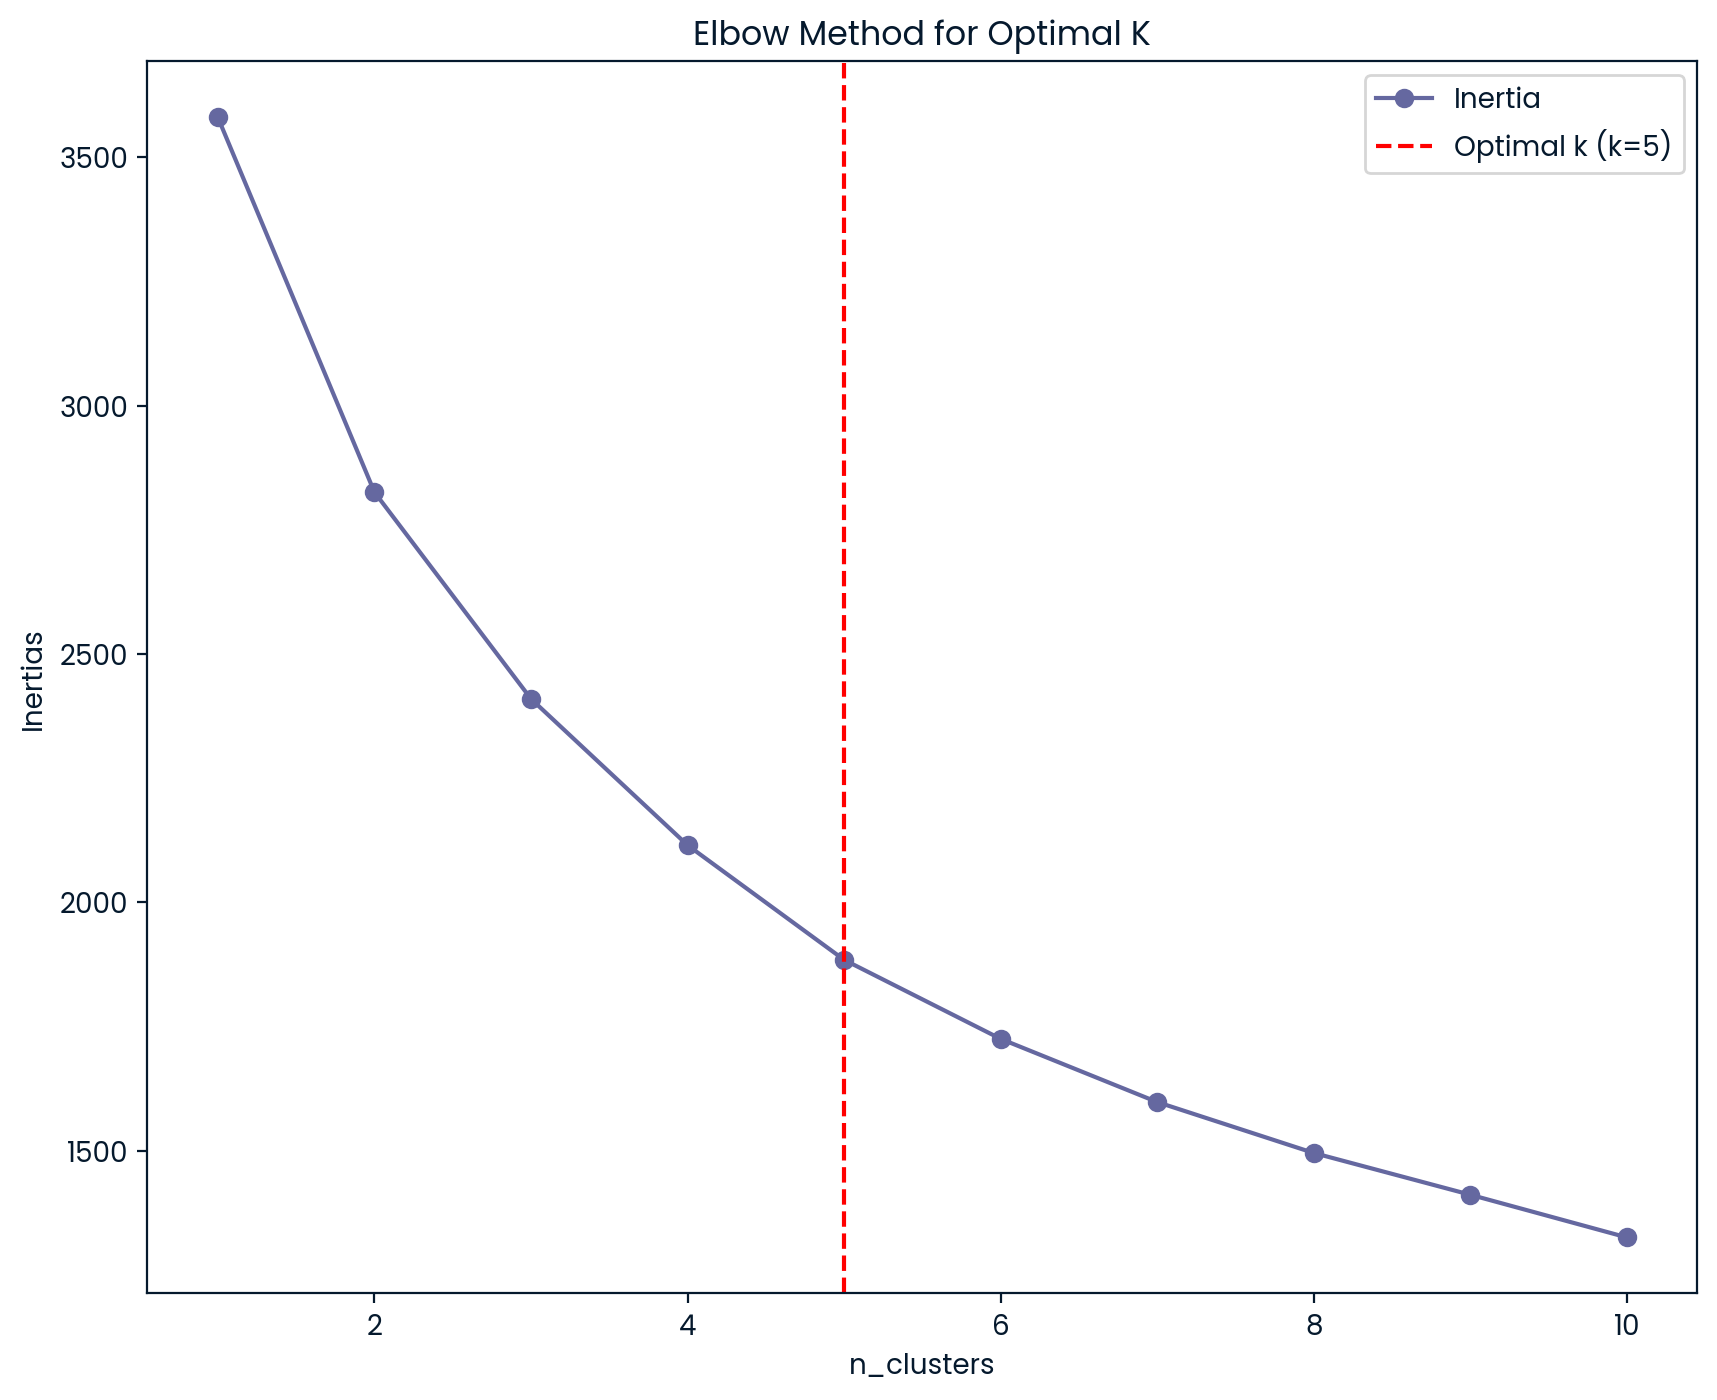

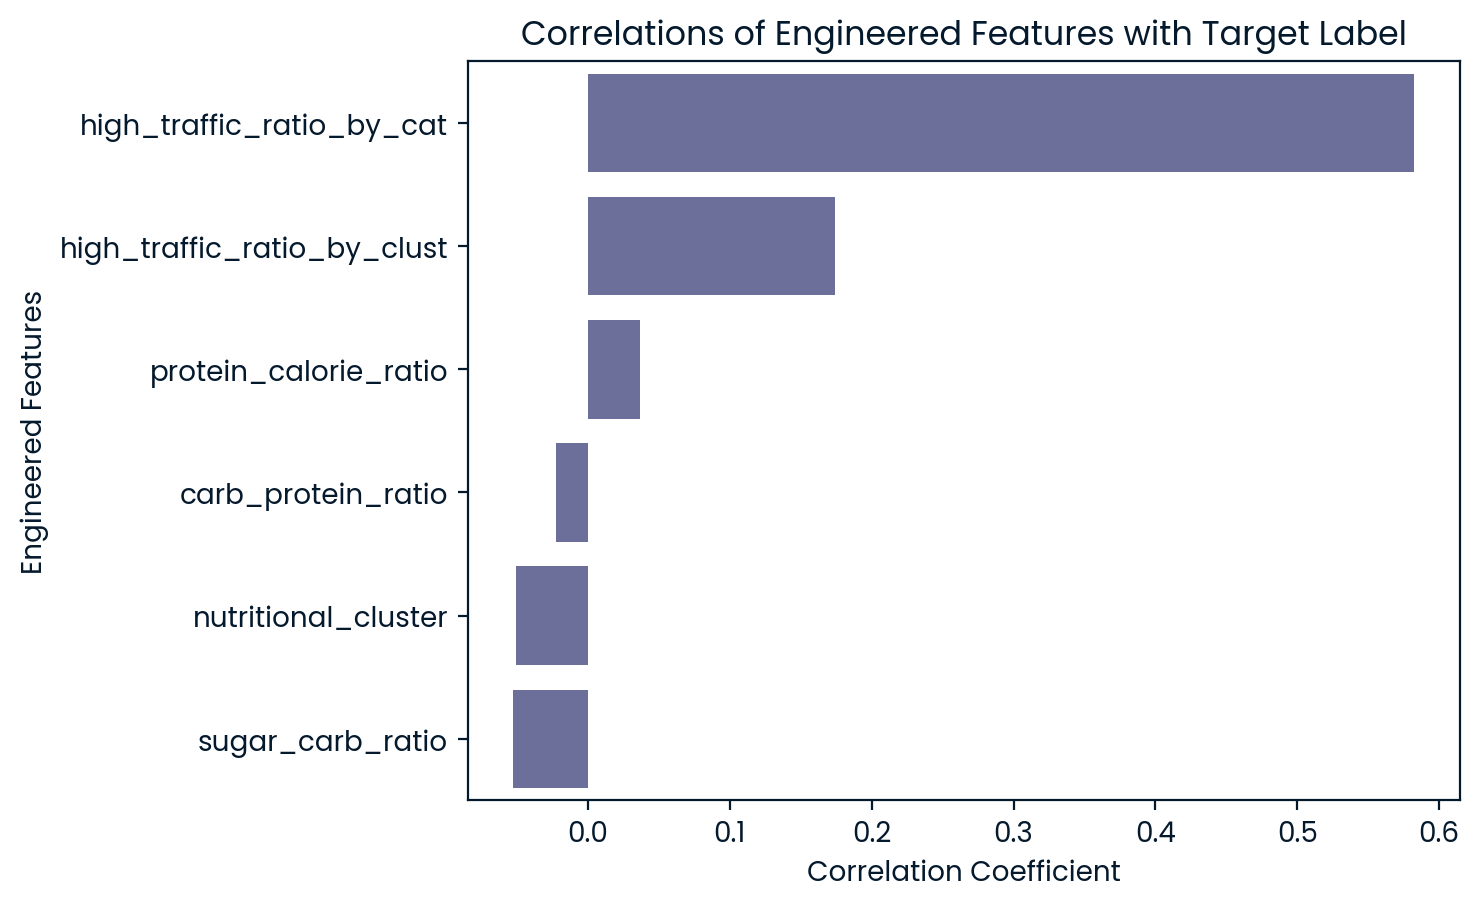

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Read in the data 
recipes_boxcox = pd.read_pickle('recipes_box_cox.pkl')
recipes_boxcox.info()

box_cox_columns = [
    'calories_boxcox', 
    'carbohydrate_boxcox', 
    'sugar_boxcox', 
    'protein_boxcox'
]

model_data = recipes_boxcox[box_cox_columns]

# Use K-means clustering to group the data based on their nutritional properties (after box_cox transformation)
scaler = StandardScaler()
scaled_model_data = scaler.fit_transform(model_data)

# Determine the correct number of clusters
inertia = []

for k in range(1,11): 
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(scaled_model_data)
    inertia.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.figure(figsize=(10,8))    
plt.plot(range(1,11), inertia, marker='o', label='Inertia')
plt.axvline(x=5, color='red', linestyle='--', label='Optimal k (k=5)')  # Add vertical line at k=5
plt.title('Elbow Method for Optimal K')
plt.xlabel('n_clusters')
plt.ylabel('Inertias')
plt.legend()  # Add legend for better interpretation
plt.savefig('figures/elbow_method_optimal_k.png', bbox_inches='tight')
plt.show();

# Select k=5 for clustering 
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
recipes_boxcox['nutritional_cluster'] = kmeans.fit_predict(scaled_model_data)

# Summarize nutritional features by cluster
cluster_summary = recipes_boxcox.groupby('nutritional_cluster')[['calories','carbohydrate','sugar','protein']].mean().round(2)
cluster_summary.to_csv('tables/cluster_summary.csv')

# Traffic ratio across clusters 
traffic_by_clust = recipes_boxcox.groupby('nutritional_cluster')['high_traffic_bool'].value_counts().unstack()
traffic_by_clust['high_traffic_ratio_by_clust'] = recipes_boxcox.groupby('nutritional_cluster')['high_traffic_bool'].sum() / recipes_boxcox.groupby('nutritional_cluster')['high_traffic_bool'].size()

# Use the traffic ratio by cluster table as a feature for the dataset
recipes_boxcox = recipes_boxcox.merge(traffic_by_clust['high_traffic_ratio_by_clust'], on='nutritional_cluster', how='left')

# Traffic ratio across categories 
traffic_by_cat = recipes_boxcox.groupby('category', observed=False)['high_traffic_bool'].value_counts().unstack()
traffic_by_cat['high_traffic_ratio_by_cat'] = recipes_boxcox.groupby('category',observed=False)['high_traffic_bool'].sum() / recipes_boxcox.groupby('category',observed=False)['high_traffic_bool'].size()

# Use the traffic ratio by category table as a feature for the dataset
recipes_boxcox = recipes_boxcox.merge(traffic_by_cat['high_traffic_ratio_by_cat'], on='category', how='left')

# Interaction Features between Nutritional Components
recipes_boxcox['protein_calorie_ratio'] = recipes_boxcox['protein'] / recipes_boxcox['calories']
recipes_boxcox['sugar_carb_ratio'] = recipes_boxcox['sugar'] / recipes_boxcox['carbohydrate']
recipes_boxcox['carb_protein_ratio'] = recipes_boxcox['carbohydrate'] / recipes_boxcox['protein']

# Category Popularity Features
category_calories = recipes_boxcox.groupby('category', observed=False)['calories'].mean()
recipes_boxcox['avg_category_calories'] = recipes_boxcox['category'].map(category_calories)

# New features and Correlation
correlation_results = (
    recipes_boxcox.drop(
        [
            'calories', 
            'carbohydrate', 
            'sugar', 
            'protein', 
            'servings',
            'calories_boxcox', 
            'carbohydrate_boxcox', 
            'sugar_boxcox',
            'protein_boxcox'
        ], 
        axis=1
    )
    .corr(numeric_only=True)
    .loc['high_traffic_bool']
    .sort_values(ascending=False)
    .drop('high_traffic_bool', axis=0)
)

sns.barplot(x=correlation_results, y=correlation_results.index, legend=False)
plt.title('Correlations of Engineered Features with Target Label')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Engineered Features') 
plt.savefig('figures/Corr_engineered_features.png', bbox_inches='tight')
plt.show();

# Save the data for Engineered data with / without Box Cox Transformations 
recipes_boxcox.drop(['calories', 'carbohydrate', 'sugar', 'protein'], axis=1).to_pickle('recipes_boxcox_engineered.pkl')
recipes_boxcox.drop(['calories_boxcox', 'carbohydrate_boxcox', 'sugar_boxcox', 'protein_boxcox'], axis=1).to_pickle('recipes_engineered.pkl')

# **Feature Engineering**

## **Objective**
The objective of this phase was to enrich the dataset by generating additional features that leverage clustering and interaction effects. These engineered features aimed to capture deeper relationships within the data, improving the predictive power of machine learning models.

## **Clustering Nutritional Profiles Using K-Means**

K-Means clustering was utilized to group recipes based on their nutritional profiles, uncovering distinct recipe segments and providing valuable insights into traffic patterns. To optimize the clustering process, the Box-Cox transformations created before were utilized in order to address skewness in the data and ensure compatibility with the algorithm’s reliance on Euclidean distances and parametric assumptions. The Elbow Method was employed to identify the optimal number of clusters, selecting five clusters, as illustrated in the plot below:

![Elbow-Method](figures/elbow_method_optimal_k.png)

**Cluster Insights**
Each cluster was analyzed for its nutritional characteristics and assigned a meaningful label. A new feature, `nutritional_cluster`, was created and assigned to each recipe. The table below summarizes the clusters:

| **Cluster** | **Label**                 | **Calories (Mean)** | **Carbohydrates (Mean)** | **Sugar (Mean)** | **Protein (Mean)** |
|-------------|---------------------------|----------------------|--------------------------|------------------|--------------------|
| 0           | High-Protein / High-Calorie | 718.73               | 9.91                     | 8.09             | 49.10             |
| 1           | Low-Calorie / Moderate-Carb | 237.52               | 17.62                    | 2.34             | 6.58              |
| 2           | Balanced / High-Protein    | 110.80               | 51.56                    | 9.65             | 37.29             |
| 3           | Sweet / Dessert-Like       | 233.58               | 26.31                    | 22.97            | 4.18              |
| 4           | High-Carb / High-Calorie   | 762.64               | 71.36                    | 5.53             | 22.43             |

## **Traffic Ratio Features**

**Traffic Ratio by Cluster**
The proportion of high-traffic recipes (`high_traffic=1`) was calculated within each nutritional cluster and stored as `high_traffic_ratio_by_clust`. This feature highlights the relative popularity of recipes within each cluster.

**Traffic Ratio by Category**
Similarly, the proportion of high-traffic recipes within each category (e.g., "Lunch/Snacks", "Dessert") was computed and stored as `high_traffic_ratio_by_cat`. This feature reflects category-level performance trends and their influence on recipe traffic.

## **Interaction Features**

To explore relationships between nutritional components, the following interaction features were introduced:
- **Protein-Calorie Ratio**: Ratio of protein to calories (`protein / calories`).
- **Sugar-Carbohydrate Ratio**: Ratio of sugar to carbohydrates (`sugar / carbohydrate`).
- **Carbohydrate-Protein Ratio**: Ratio of carbohydrates to protein (`carbohydrate / protein`).

These features were designed to uncover more granular relationships between nutritional composition and recipe popularity.

## **Category Popularity Features**

A feature named `avg_category_calories` was created by calculating the average calories for recipes within each category. This feature contextualizes trends within categories, offering insights into consumer preferences and typical caloric content.

## **New Features and Correlation**

The correlation analysis revealed the following relationships between the engineered features and high traffic:

![Corr-eng-feat](figures/Corr_engineered_features.png)

**Key Findings:**
- **Strongest Correlation**: `high_traffic_ratio_by_cat` exhibited the highest positive correlation with high traffic (0.58), indicating that recipes from popular categories are more likely to generate high traffic.
- **Moderate Correlation**: `high_traffic_ratio_by_clust` showed a moderate correlation (0.17), suggesting nutritional clusters influence traffic but less significantly than category popularity.
- **Weaker Correlations**: Features like `protein_calorie_ratio` (0.04), `carb_protein_ratio` (-0.02), `nutritional_cluster` (-0.05), and `sugar_carb_ratio` (-0.05) displayed weak linear relationships with high traffic. Despite this, they may still capture non-linear patterns that advanced models can exploit.

## **Conclusion for Feature Engineering**

1. **Clustering Enhancements**: Nutritional clustering enabled the abstraction of complex relationships into meaningful segments, potentially reflecting consumer preferences.
2. **Traffic Ratios**: Features such as `high_traffic_ratio_by_cat` and `high_traffic_ratio_by_clust` provided valuable insights into recipe popularity, with the former demonstrating strong predictive potential.
3. **Interaction Features**: While linear correlations for interaction features were weak, they may reveal non-linear patterns when used in sophisticated models.
4. **Category Popularity Features**: Features like `avg_category_calories` contextualize recipe trends, aligning with observed correlations between category-level popularity and high traffic.

These engineered features enhanced the dataset’s representation, laying a strong foundation for the modeling phase. The next section will detail the models developed and their performance in predicting high-traffic recipes.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

RESULTS FOR LOGISTIC REGRESSION WITH BOX-COX TRANSFORMATIONS
              precision    recall  f1-score   support

        High       0.80      0.82      0.81       107
       Other       0.72      0.69      0.71        72

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


ROC AUC SCORE:  0.8369678089304258
Best parameters found:  {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


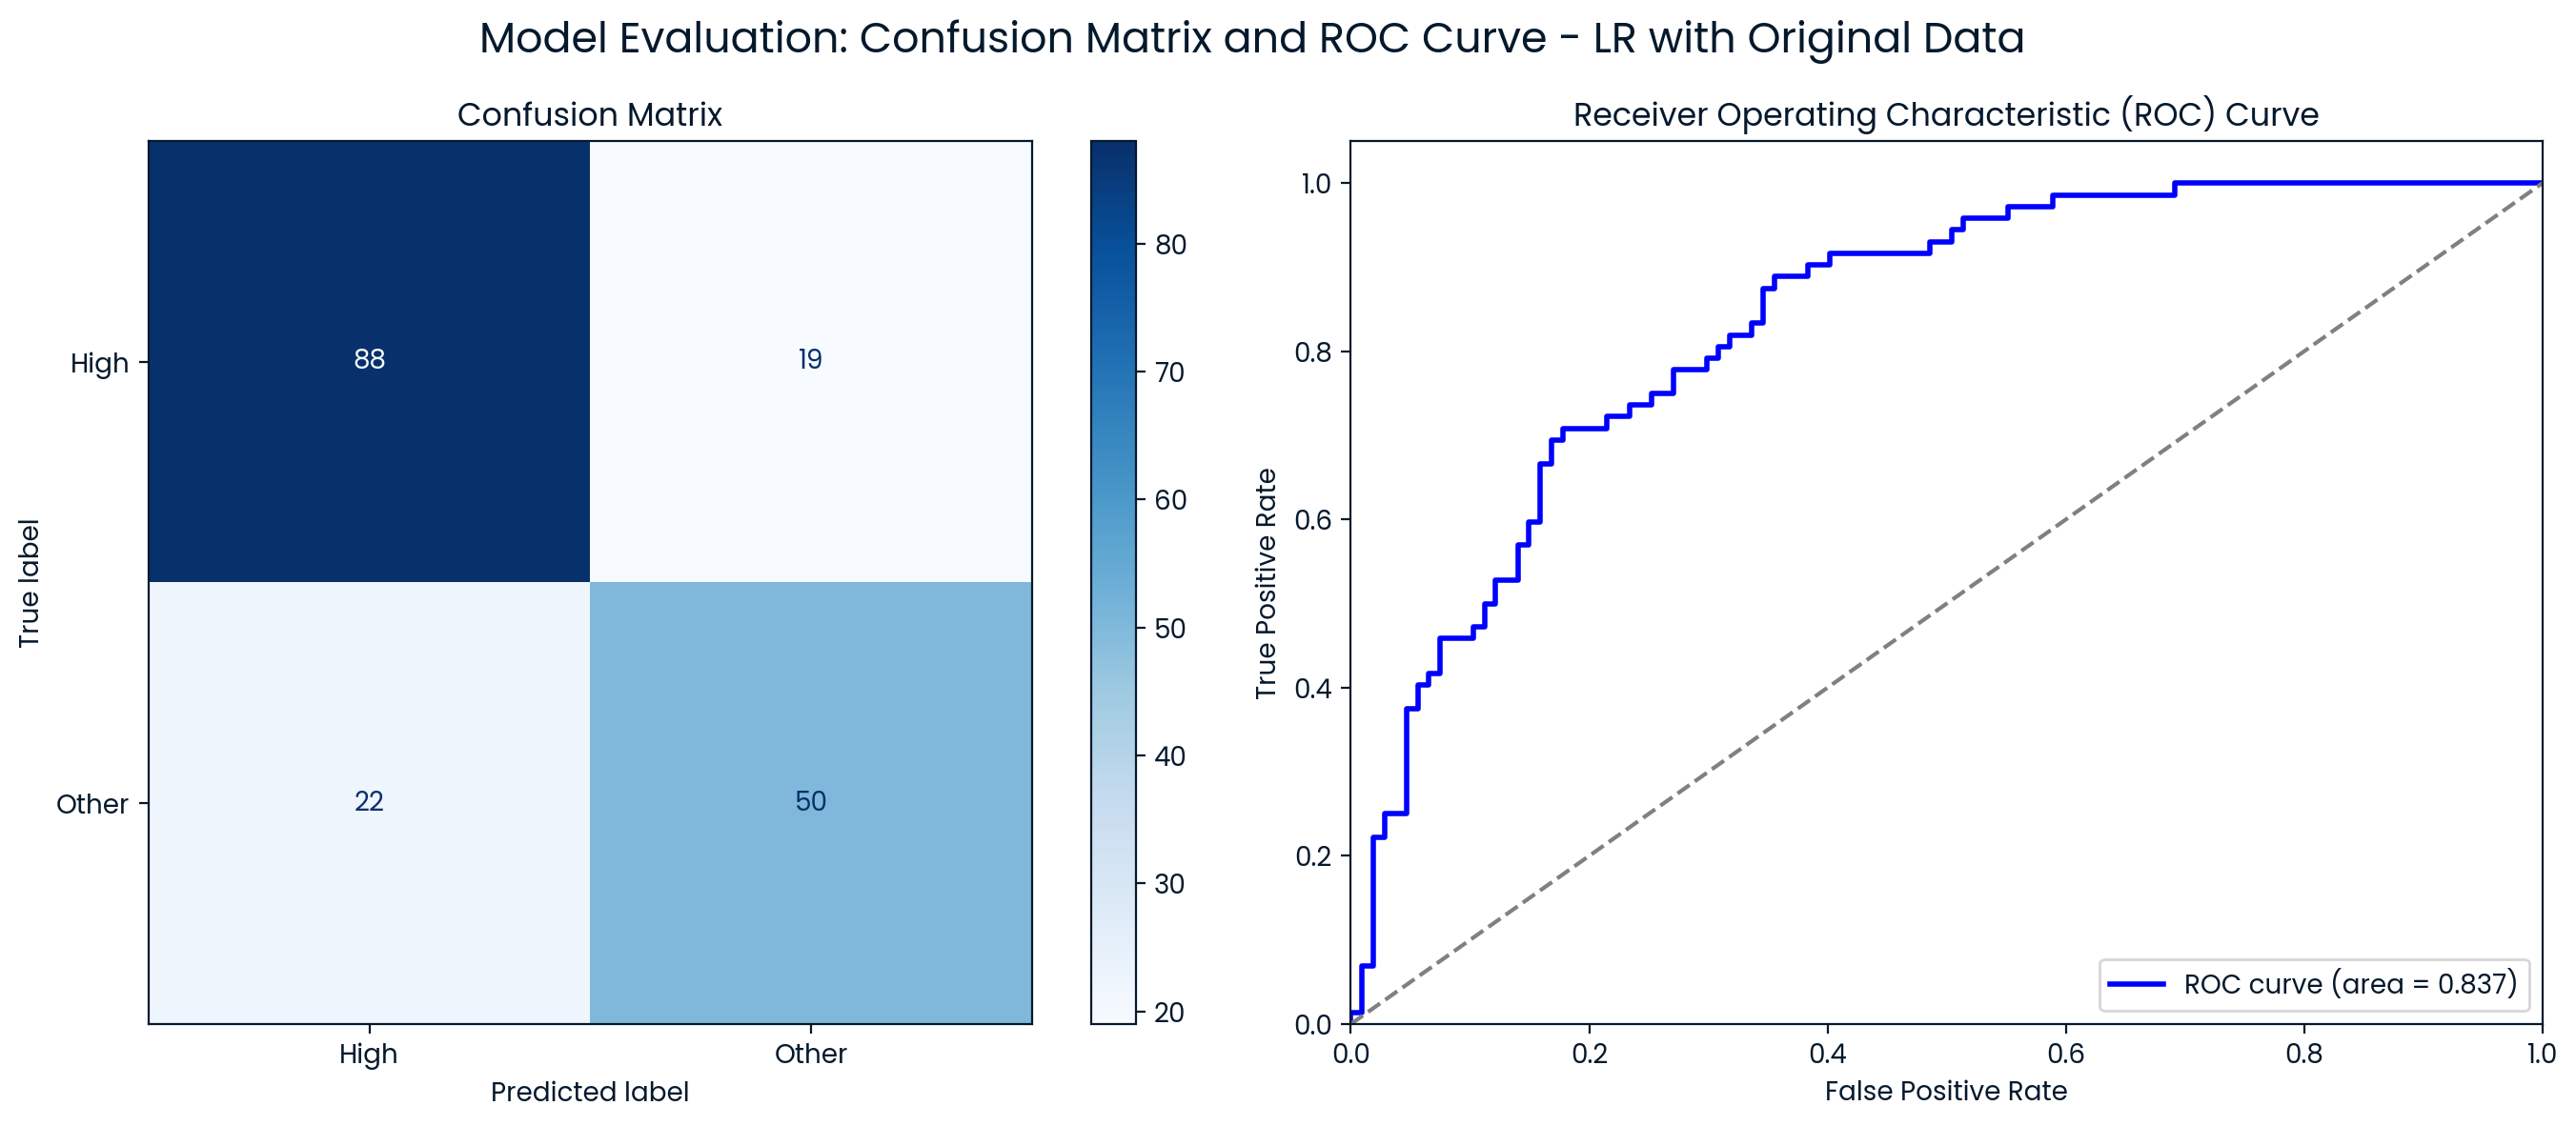

Top 10 Features by Coefficient (original Data)
                  Feature  Coefficient
0      category_Beverages     3.729609
1      category_Breakfast     1.333115
2        category_Chicken     0.900239
3        category_Dessert     0.076863
11        calories_boxcox     0.050432
13           sugar_boxcox     0.038420
12    carbohydrate_boxcox     0.022155
4   category_Lunch/Snacks     0.000000
14         protein_boxcox    -0.057196
10               servings    -0.074760
----------------------

Fitting 5 folds for each of 20 candidates, totalling 100 fits

RESULTS FOR LOGISTIC REGRESSION WITH ENGINEERED DATA
              precision    recall  f1-score   support

        High       0.81      0.82      0.81       107
       Other       0.73      0.71      0.72        72

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179


ROC AUC SCORE:  0.843717549325026
Best parameters found:

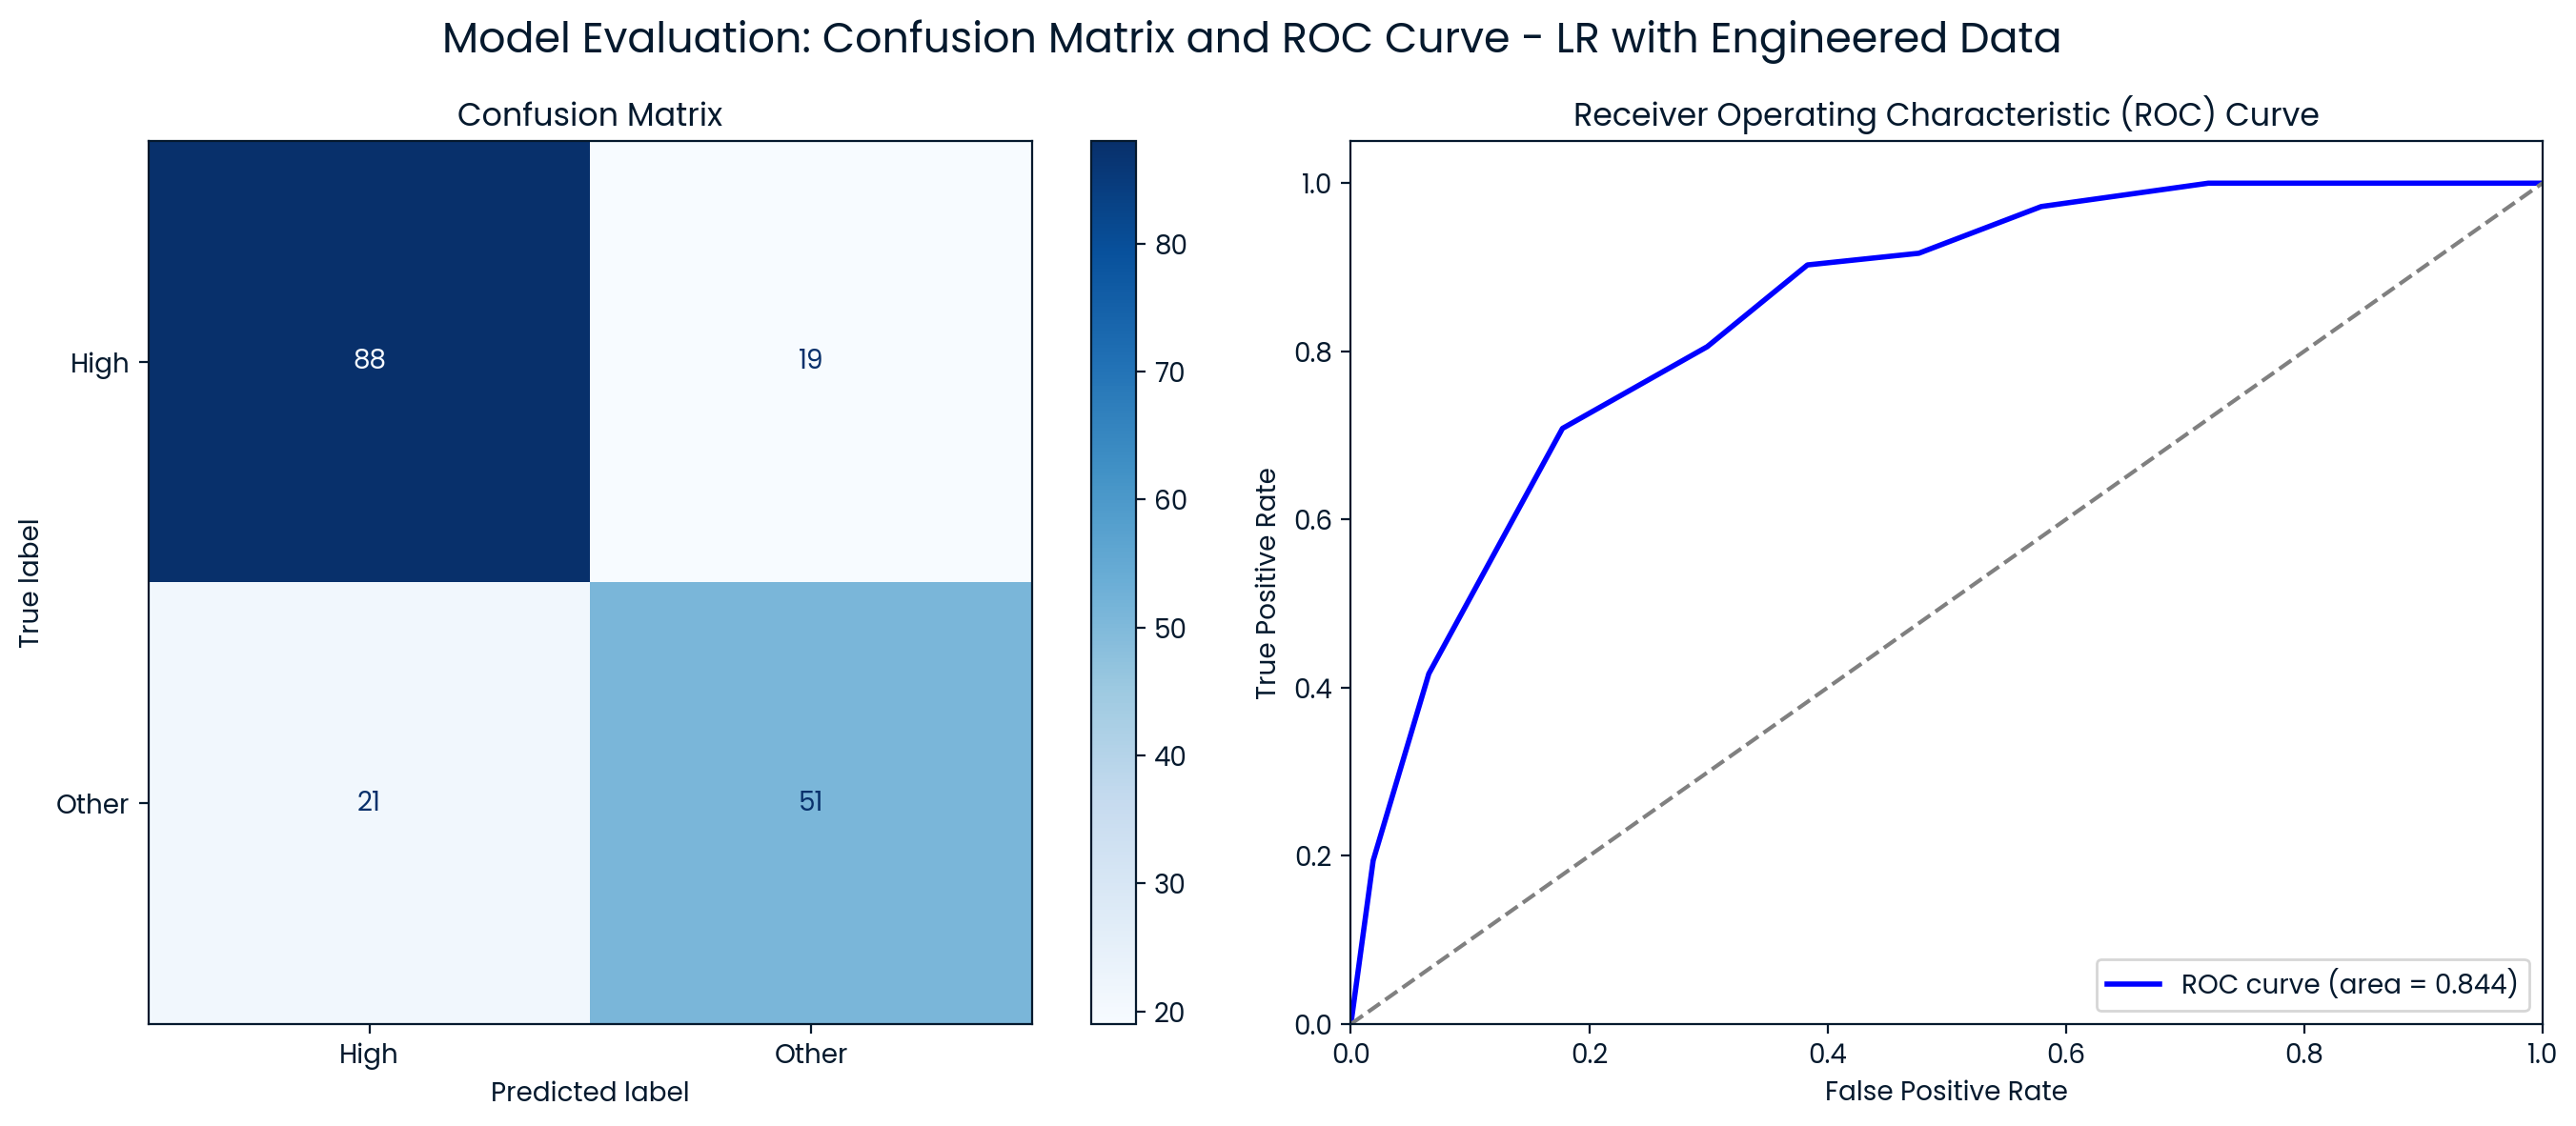

Top 10 Features by Coefficient (Engineered Data)
                        Feature  Coefficient
0            category_Beverages          0.0
1            category_Breakfast          0.0
24           carb_protein_ratio          0.0
23             sugar_carb_ratio          0.0
22        protein_calorie_ratio          0.0
20  high_traffic_ratio_by_clust          0.0
19               protein_boxcox          0.0
18                 sugar_boxcox          0.0
17          carbohydrate_boxcox          0.0
16              calories_boxcox          0.0


In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier

# ------------------------------------------------------------------
# Logistic Regression with box-cox transformations

# Read in data
recipes_base = pd.read_pickle('recipes_box_cox.pkl')

# Features and Target
X = recipes_base.drop(['high_traffic','high_traffic_bool', 'calories', 'carbohydrate', 'sugar', 'protein'], axis=1)
y = recipes_base['high_traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numerical and categorical features
categorical_columns = ['category']
numerical_columns = [col for col in X.columns if col not in categorical_columns]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Instantiate Logistic Regression Model 
log_reg = LogisticRegression(
    max_iter = 10000, 
    random_state=42
)

# Create a Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_reg)
])

# Hyperparameter Tunning
param_grid_lr = {
    'model__penalty': ['l1', 'l2'],                  
    'model__C': [0.01, 0.1, 1, 10, 100],            
    'model__solver': ['liblinear', 'saga']   
}

# GridSearchCV 
grid = GridSearchCV(
    pipeline, 
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid.fit(X_train, y_train)

# Evaluate 
y_pred = grid.predict(X_test)
y_pred_proba = grid.predict_proba(X_test)[:,1]
print('\nRESULTS FOR LOGISTIC REGRESSION WITH BOX-COX TRANSFORMATIONS')
print(classification_report(y_test, y_pred))
print('\nROC AUC SCORE: ', roc_auc_score(y_test, y_pred_proba))
print('Best parameters found: ', grid.best_params_)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Other')
roc_auc = auc(fpr, tpr)

# Set up the matplotlib figure with two subplots on the same row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Model Evaluation: Confusion Matrix and ROC Curve - LR with Original Data', fontsize=16)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Other']).plot(cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

# Save and Display the plot
plt.savefig('figures/logistic_regression_OD_evaluation.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Extract Coefficients for Logistic Regression with Original Data
preprocessor_fitted = grid.best_estimator_.named_steps['preprocessor']
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = list(cat_feature_names) + numerical_columns
coefs = grid.best_estimator_.named_steps['model'].coef_[0]

# Create a DataFrame to view the feature names and their corresponding coefficients
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,  
    'Coefficient': coefs 
})

# Sort the features by the magnitude of the coefficient (ascending order)
feature_importances = feature_importances.sort_values(by='Coefficient', ascending=False)
print('Top 10 Features by Coefficient (original Data)')
print(feature_importances.head(10))

print('----------------------\n')

# ------------------------------------------------------------------
# Logistic Regression with Engineered Data

# Read in data 
recipes = pd.read_pickle('recipes_boxcox_engineered.pkl')

# Features and Split
X = recipes.drop(['high_traffic', 'high_traffic_bool'], axis=1)
y = recipes['high_traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numerical and categorical features
categorical_columns = ['category', 'nutritional_cluster']
numerical_columns = [
    'servings',
    'calories_boxcox',
    'carbohydrate_boxcox',
    'sugar_boxcox',
    'protein_boxcox',
    'high_traffic_ratio_by_clust',
    'high_traffic_ratio_by_cat',
    'protein_calorie_ratio',
    'sugar_carb_ratio',
    'carb_protein_ratio',
    'avg_category_calories'
]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Pipeline for processing and training the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', log_reg)
])

# Hyperparameter Tunning
param_grid_lr = {
    'model__penalty': ['l1', 'l2'],                  
    'model__C': [0.01, 0.1, 1, 10, 100],            
    'model__solver': ['liblinear', 'saga'],    
}

# GridSearchCV 
grid = GridSearchCV(
    pipeline, 
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid.fit(X_train, y_train)

# Model Evaluation 
# ----------------

y_pred = grid.predict(X_test)
y_pred_proba = grid.predict_proba(X_test)[:,1]
print('\nRESULTS FOR LOGISTIC REGRESSION WITH ENGINEERED DATA')
print(classification_report(y_test, y_pred))
print('\nROC AUC SCORE: ', roc_auc_score(y_test, y_pred_proba))
print('Best parameters found: ', grid.best_params_)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Other')
roc_auc = auc(fpr, tpr)

# Set up the matplotlib figure with two subplots on the same row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Model Evaluation: Confusion Matrix and ROC Curve - LR with Engineered Data', fontsize=16)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Other']).plot(cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

# Save and Display the plot
plt.savefig('figures/logistic_regression_ED_evaluation.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Extract Coefficients for Logistic Regression with Original Data
preprocessor_fitted = grid.best_estimator_.named_steps['preprocessor']
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = list(cat_feature_names) + numerical_columns
coefs = grid.best_estimator_.named_steps['model'].coef_[0]

# Create a DataFrame to view the feature names and their corresponding coefficients
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,  
    'Coefficient': coefs 
})

# Sort the features by the magnitude of the coefficient (ascending order)
feature_importances = feature_importances.sort_values(by='Coefficient')
print('Top 10 Features by Coefficient (Engineered Data)')
print(feature_importances.head(10))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
RESULTS FOR RANDOM FOREST WITH ORIGINAL DATA
              precision    recall  f1-score   support

        High       0.73      0.84      0.78       107
       Other       0.69      0.53      0.60        72

    accuracy                           0.72       179
   macro avg       0.71      0.68      0.69       179
weighted avg       0.71      0.72      0.71       179

Best parameters found:  {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}

ROC AUC SCORE:  0.8177570093457944


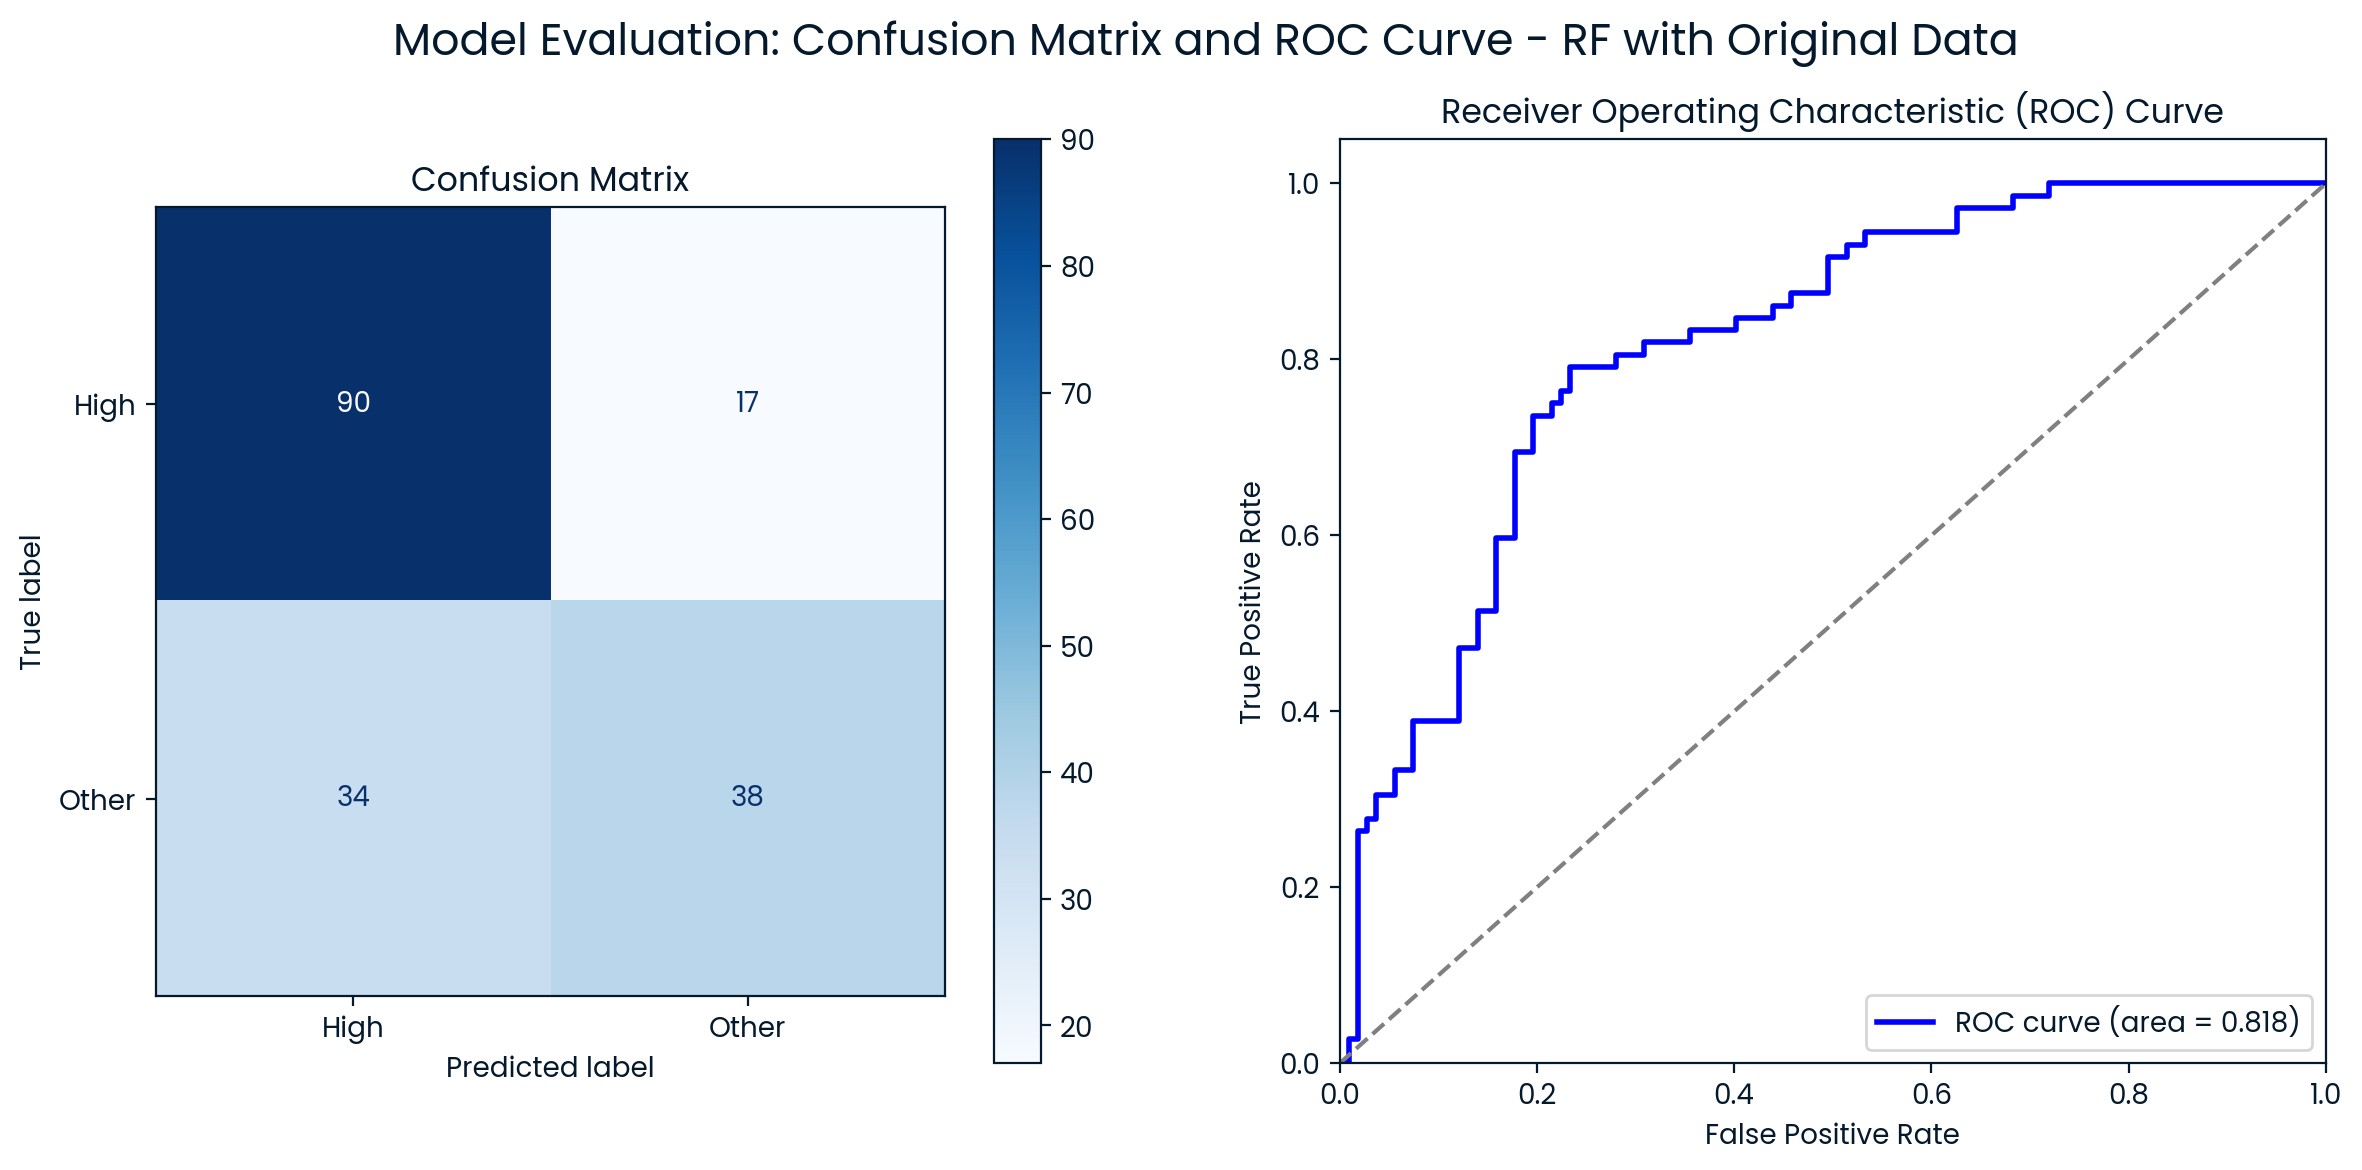

Top 10 Features by Importance (Original Data)
               Feature  Importance
0   category_Beverages    0.181746
14             protein    0.171392
11            calories    0.097692
13               sugar    0.097073
12        carbohydrate    0.087741
1   category_Breakfast    0.080657
9   category_Vegetable    0.079779
8      category_Potato    0.051572
2     category_Chicken    0.051517
7        category_Pork    0.037942
-------------------------------------------------------------

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
RESULTS FOR RANDOM FOREST WITH ENGINEERED FEATURES
              precision    recall  f1-score   support

        High       0.76      0.83      0.79       107
       Other       0.71      0.61      0.66        72

    accuracy                           0.74       179
   macro avg       0.74      0.72      0.73       179
weighted avg       0.74      0.74      0.74       179


ROC AUC SCORE:  0.8056853582554517
Best parameters found:  {'mo

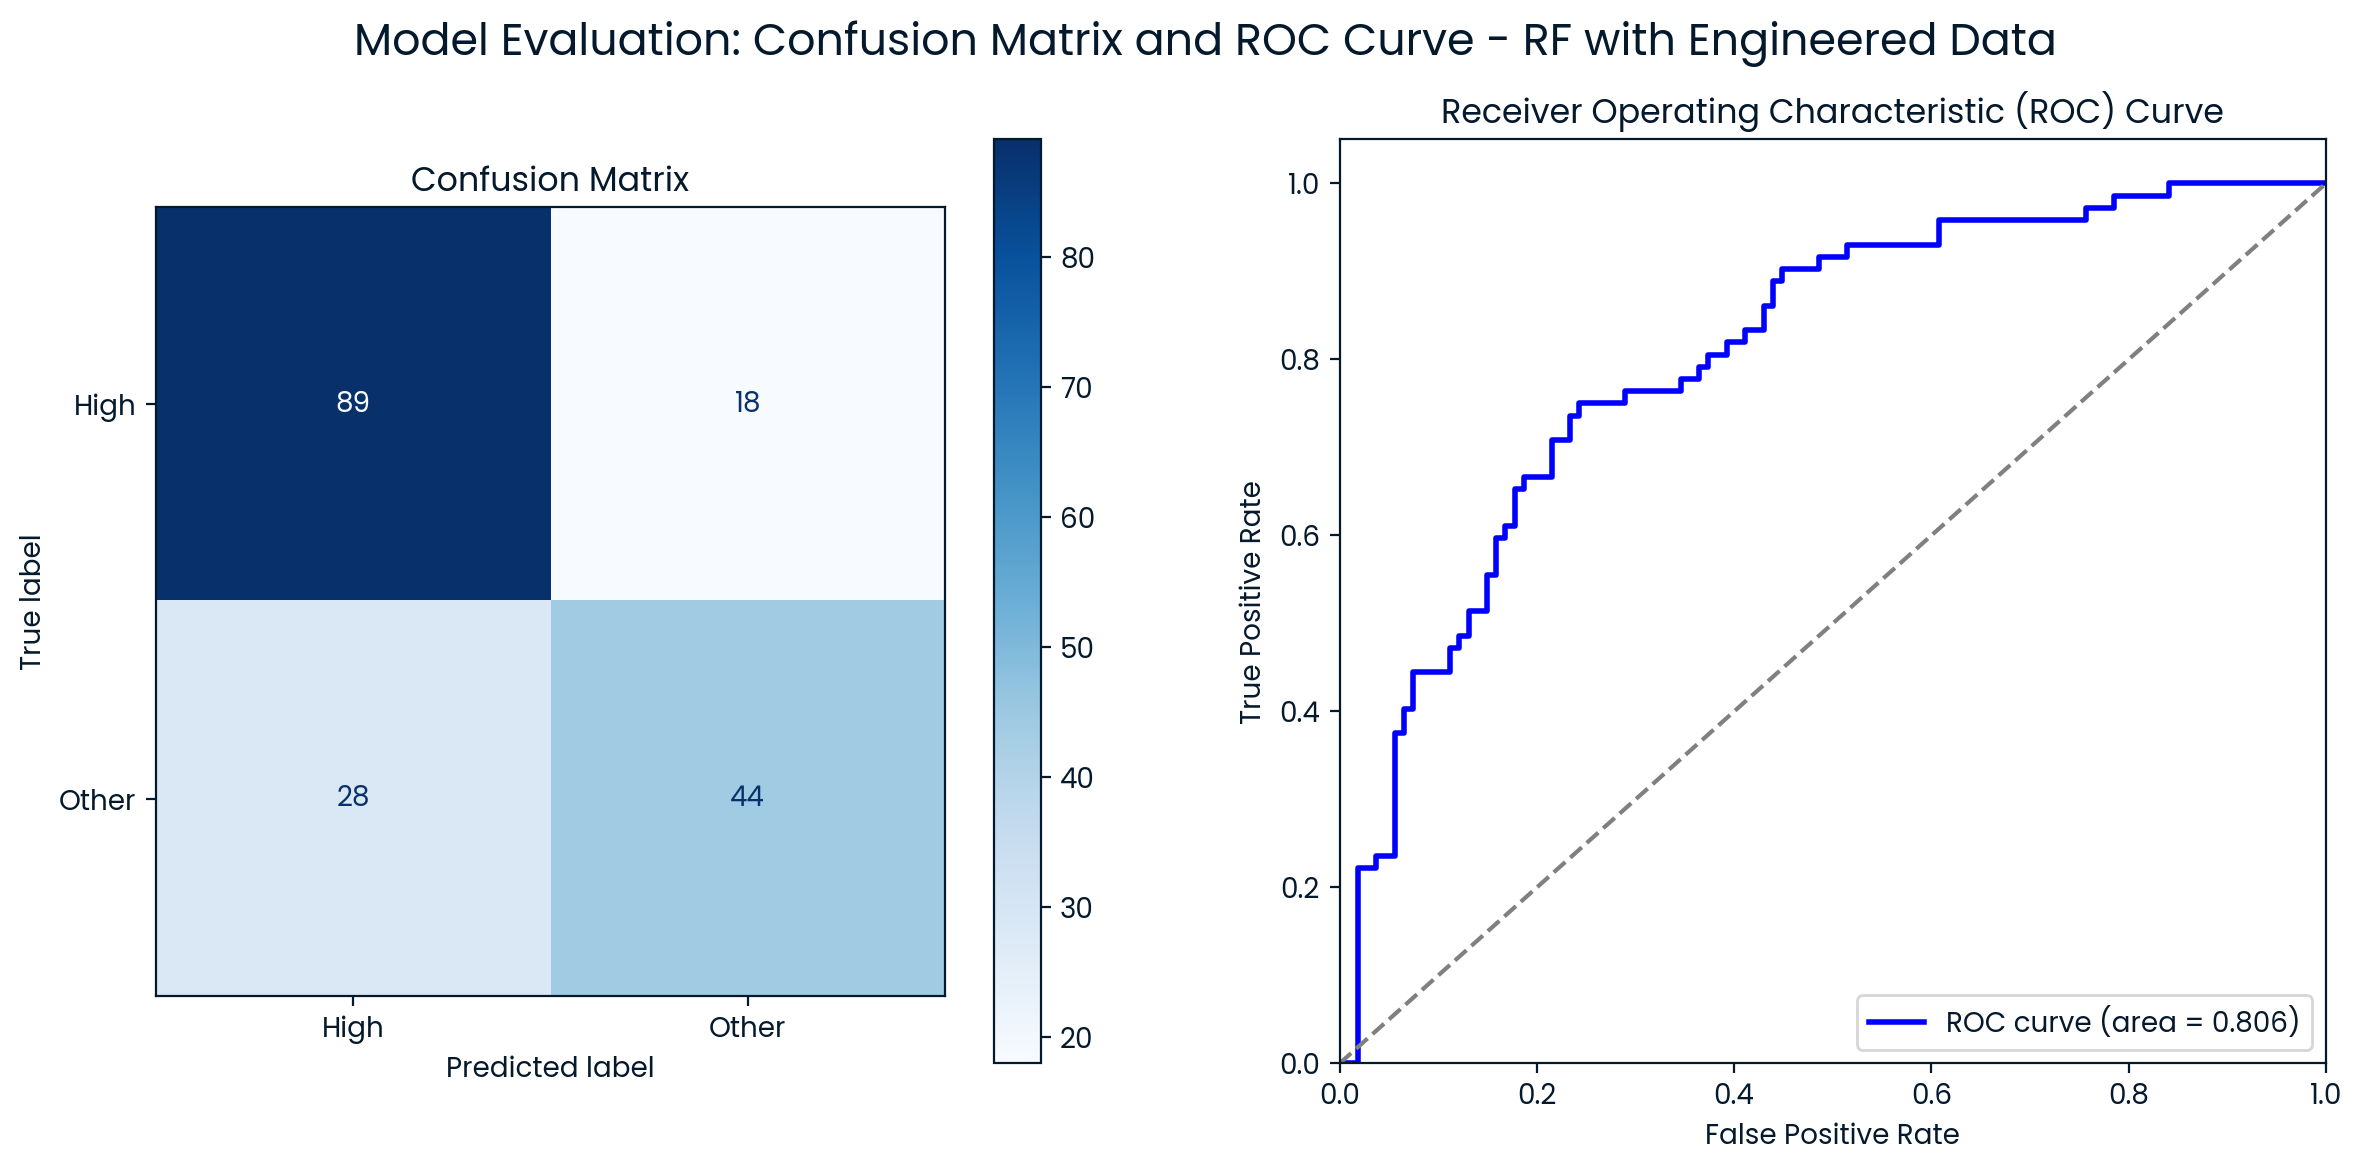

Top 10 Features by Importance (Engineered Data)
                      Feature  Importance
25  high_traffic_ratio_by_cat    0.187071
23      avg_category_calories    0.106240
18                    protein    0.088855
22         carb_protein_ratio    0.062702
20      protein_calorie_ratio    0.062300
0          category_Beverages    0.061785
15                   calories    0.057273
21           sugar_carb_ratio    0.052827
17                      sugar    0.052806
16               carbohydrate    0.049934


In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier

# ------------------------------------------------------------------
# Random Forests with base data 

# Read in data
recipes = pd.read_pickle('recipes_site_traffic_clean.pkl')

# Features and Target 
X = recipes.drop(['high_traffic', 'high_traffic_bool'], axis=1)    
y = recipes['high_traffic']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numerical and categorical features
categorical_columns = ['category']
numerical_columns = [
    'servings',
    'calories',
    'carbohydrate',
    'sugar',
    'protein'
]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Instantiate Decision Tree Model (base params)
rf = RandomForestClassifier(
    random_state=42,
)

# Create a Pipeline 
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Hyperparameter Tunning
param_grid_rf = {
    'model__n_estimators': [100, 200, 500],  
    'model__max_depth': [None, 10, 20, 30],  
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],   
    'model__max_features': ['sqrt', 'log2'], 
    'model__bootstrap': [True, False]
}

# GridSearchCV setup
grid_rf = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

# Assuming 'X_train' and 'y_train' are already defined
grid_rf.fit(X_train, y_train)

# Print the best parameters
print('RESULTS FOR RANDOM FOREST WITH ORIGINAL DATA')

# Evaluate the model on the test set
y_pred_rf = grid_rf.predict(X_test)
y_pred_proba = grid_rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
print('Best parameters found: ', grid_rf.best_params_)
print('\nROC AUC SCORE: ', roc_auc_score(y_test, y_pred_proba))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Other')
roc_auc = auc(fpr, tpr)

# Set up the matplotlib figure with two subplots on the same row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Model Evaluation: Confusion Matrix and ROC Curve - RF with Original Data', fontsize=16)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Other']).plot(cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")
plt.savefig('figures/RF_OD_evaluation.png', bbox_inches='tight')
plt.show()

# Access feature importances
importances = grid_rf.best_estimator_.named_steps['model'].feature_importances_

# Get feature names from the preprocessor
categorical_features = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
numerical_features = numerical_columns  # Use the numerical columns from your data

# Combine feature names
all_feature_names = list(categorical_features) + list(numerical_features)

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print('Top 10 Features by Importance (Original Data)')
print(feature_importance_df.head(10))

print('-------------------------------------------------------------\n')

# ------------------------------------------------------------------
# Random Forest with Engineered Features

# Read in data
recipes_engineered = pd.read_pickle('recipes_engineered.pkl')

# Features and Target 
X = recipes_engineered.drop(['high_traffic', 'high_traffic_bool'], axis=1)    
y = recipes_engineered['high_traffic']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numerical and categorical features
categorical_columns = ['category', 'nutritional_cluster']
numerical_columns = [
    'calories',
    'carbohydrate',
    'sugar',
    'protein',
    'servings',
    'protein_calorie_ratio',
    'sugar_carb_ratio',
    'carb_protein_ratio',
    'avg_category_calories',
    'high_traffic_ratio_by_clust',
    'high_traffic_ratio_by_cat'
 ]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
        ('num', 'passthrough', numerical_columns)
    ]
)

# Create a Pipeline 
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Hyperparameter Tunning
param_grid_rf = {
    'model__n_estimators': [100, 200, 500],  
    'model__max_depth': [None, 10, 20, 30],  
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],   
    'model__max_features': ['sqrt', 'log2'], 
    'model__bootstrap': [True, False], 
}

# GridSearchCV setup
grid_rf = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

# Assuming 'X_train' and 'y_train' are already defined
grid_rf.fit(X_train, y_train)

# Print the best parameters
print('RESULTS FOR RANDOM FOREST WITH ENGINEERED FEATURES')

# Evaluate the model on the test set
y_pred_rf = grid_rf.predict(X_test)
y_pred_proba = grid_rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
print('\nROC AUC SCORE: ', roc_auc_score(y_test, y_pred_proba))
print('Best parameters found: ', grid_rf.best_params_)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='Other')
roc_auc = auc(fpr, tpr)

# Set up the matplotlib figure with two subplots on the same row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Model Evaluation: Confusion Matrix and ROC Curve - RF with Engineered Data', fontsize=16)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Other']).plot(cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")
plt.savefig('figures/RF_ED_evaluation.png', bbox_inches='tight')
plt.show()

# Access feature importances
importances = grid_rf.best_estimator_.named_steps['model'].feature_importances_

# Get feature names from the preprocessor
categorical_features = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
numerical_features = numerical_columns  # Use the numerical columns from your data

# Combine feature names
all_feature_names = list(categorical_features) + list(numerical_features)

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print('Top 10 Features by Importance (Engineered Data)')
print(feature_importance_df.head(10))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for the meta-model: {'final_estimator__C': 10, 'final_estimator__penalty': 'l1'}
              precision    recall  f1-score   support

        High       0.82      0.80      0.81       107
       Other       0.72      0.74      0.73        72

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

ROC AUC SCORE: 0.8346313603322949
Meta-Model Coefficients:
  Base Model  Coefficient
0     logreg     3.778017
1         rf     1.487106


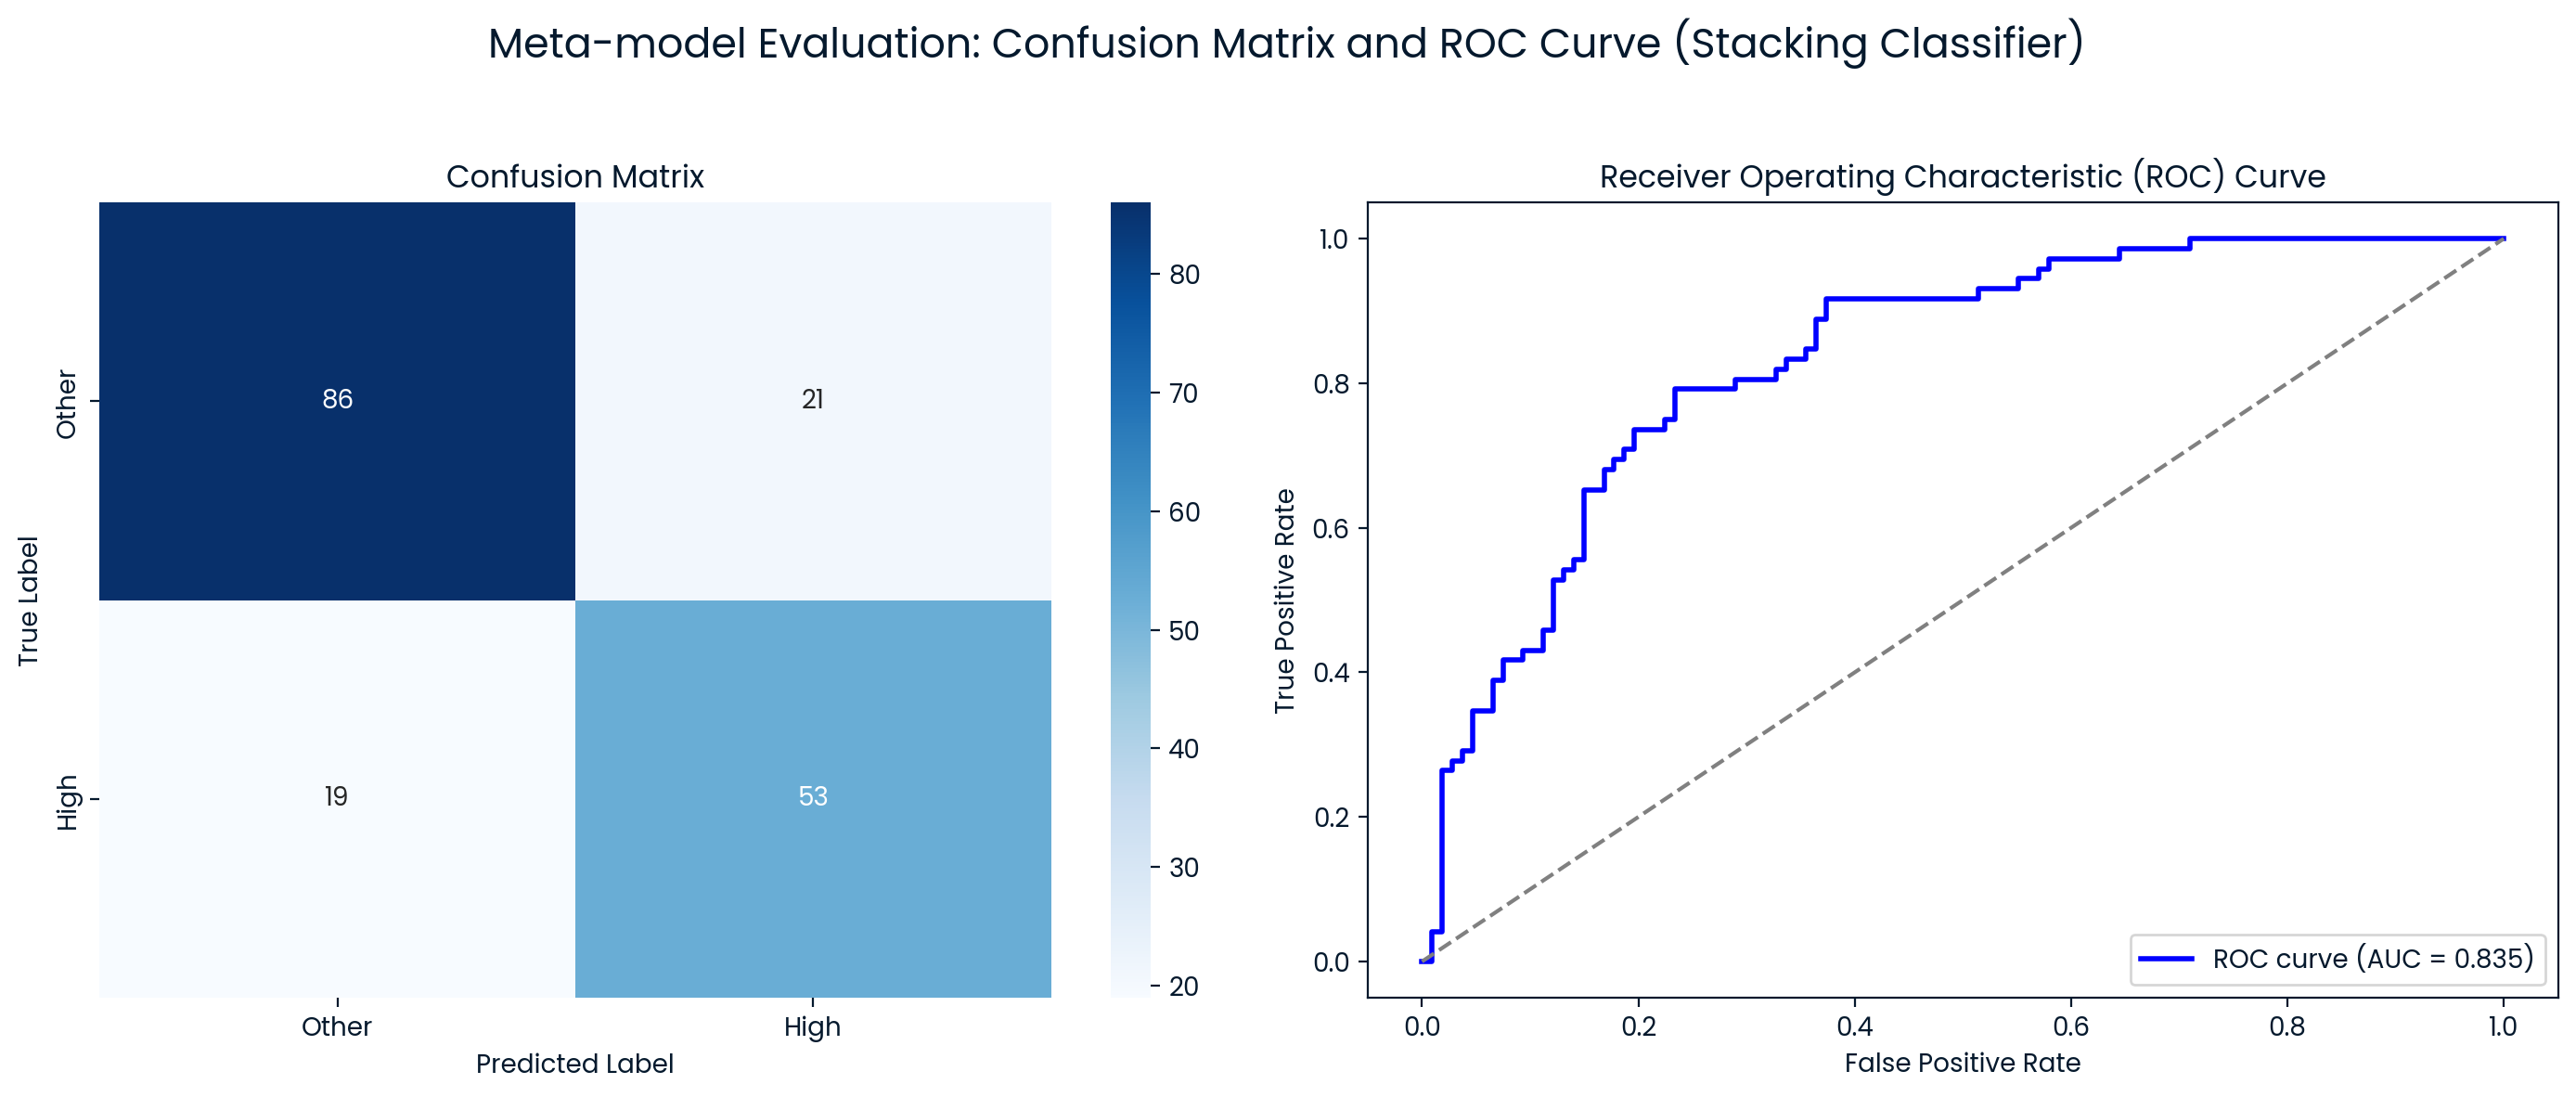

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# ------------------------------------------------------------------
# Custom Transformer to add a small constant to specified columns

class AddConstantTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to add a small constant to specified columns.
    """
    def __init__(self, constant=1, columns=None):
        self.constant = constant
        self.columns = columns  # Columns to apply the transformation

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.columns is not None:
            X[self.columns] += self.constant
        return X


# ------------------------------------------------------------------
# Voting Classifier with RandomForest, LogReg, and Gradient Boosting

# Read in data
recipes = pd.read_pickle('recipes_site_traffic_clean.pkl')

# Features and Target
X = recipes.drop(['high_traffic', 'high_traffic_bool'], axis=1)
y = recipes['high_traffic']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Separate numerical and categorical features
categorical_columns = ['category']
numerical_columns = ['servings', 'calories', 'carbohydrate', 'sugar', 'protein']

# ------------------------------------ # 
# Logistic Regression                  #
# ------------------------------------ #

# Preprocessor for Logistic Regression
logreg_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', Pipeline([
            ('add_constant', AddConstantTransformer(constant=1, columns=['calories', 'carbohydrate', 'sugar', 'protein'])),  # Add constant to columns
            ('boxcox', PowerTransformer(method='box-cox')),  # Apply Box-Cox Transformation
            ('scaler', StandardScaler())  # Scale features
        ]), numerical_columns)
    ]
)

# Logistic Regression model with best hyperparameters
logreg = LogisticRegression(
    C=10, 
    penalty='l1', 
    solver='liblinear', 
    class_weight='balanced',
    random_state=42
)

# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', logreg_preprocessor),
    ('model', logreg)
])

# ------------------------------------ # 
# Random Forest                        #
# ------------------------------------ #

# Random Forest model with best hyperparameters
rf = RandomForestClassifier(
    bootstrap=True, 
    max_depth=10, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=200, 
    random_state=42,
    class_weight='balanced',
)

# Random Forest preprocessor
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)  # Standard scaler only, no Box-Cox
    ]
)

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('model', rf)
])

# ------------------------------------ #
# Stacking Classifier                  #
# ------------------------------------ #

# Base models as before
base_models = [
    ('logreg', logreg_pipeline),
    ('rf', rf_pipeline)
]

# Meta-model (Logistic Regression) 

# Define a meta-model (Logistic Regression)
meta_model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

# Stacking Classifier              

# Create Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Parameter grid for the meta-model
param_grid_stacking = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100],  
    'final_estimator__penalty': ['l1', 'l2'],        
}

# Stacking Classifier with GridSearchCV
grid_search_stacking = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid_stacking,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV with Stacking Classifier
grid_search_stacking.fit(X_train, y_train)

# Best parameters for the meta-model
print("Best parameters for the meta-model:", grid_search_stacking.best_params_)

# Evaluate the optimized Stacking Classifier
y_pred = grid_search_stacking.predict(X_test)
y_prob = grid_search_stacking.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print(classification_report(y_test, y_pred))
print('ROC AUC SCORE:', roc_auc_score(y_test, y_prob))

# Extract coefficients from the meta-model
meta_model_coefs = grid_search_stacking.best_estimator_.final_estimator_.coef_[0]

# Get base model names as "features"
base_model_names = [name for name, _ in base_models]

# Create a DataFrame for visualization
meta_model_importance_df = pd.DataFrame({
    'Base Model': base_model_names,
    'Coefficient': meta_model_coefs
}).sort_values(by='Coefficient', ascending=False)

print("Meta-Model Coefficients:")
print(meta_model_importance_df)

# Extract the best estimator (optimized StackingClassifier)
best_stacking_clf = grid_search_stacking.best_estimator_

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Other')
roc_auc = auc(fpr, tpr)

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the confusion matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Other', 'High'], yticklabels=['Other', 'High'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')

# Adjust layout and show the figure
fig.suptitle('Meta-model Evaluation: Confusion Matrix and ROC Curve (Stacking Classifier)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figures/stacking_classifier_evaluation.png', bbox_inches='tight')
plt.show()

# Model Development

As outlined in the introduction, the objective of this project is to accurately identify recipes that can drive increased website traffic. This project addresses a **binary classification problem**, where the goal is to predict whether a recipe will generate high traffic (`High`) or not (`Other`). Specifically, the aim is to correctly predict high-traffic recipes at least 80% of the time while minimizing the likelihood of recommending unpopular recipes.

To achieve this, the following machine learning models were explored: **Logistic Regression**, **Random Forest Classifier**, and a **Stacking Classifier** that combined the strengths of both LR and RF models and reduced their weaknesses.

These models were trained and evaluated using both the **original dataset** and the **engineered dataset** developed during the Feature Engineering section of this project. This was done to assess the impact of feature engineering on predictive performance. A **5-fold cross-validation** was used for hyperparameter tunning and to ensure each model achieves its optimal configuration. This iterative process allowed the selection of the best parameters while maintaining robust performance across different subsets of the data.

It's important to note that in all models, the class labeled as 'Other' was considered as the **positive class** 

## **Evaluation Framework**

The success of the models was evaluated based on their ability to meet the following business-driven criteria:

### **Primary Metric**
- **F1-Score for the "High" Class**: The primary metric, emphasizing the balance between precision and recall, with a target of **≥ 0.80** for the "High" class.

### **Supporting Metrics**
- **Precision for the "High" Class**: Measures the proportion of correctly identified high-traffic recipes among those predicted as such, with a threshold of **≥ 0.80**.
- **Recall for the "High" Class**: Assesses the proportion of actual high-traffic recipes that are correctly identified, also with a target of **≥ 0.80**.
- **Precision for the “Other” Class**: Minimizes the risk of recommending unpopular recipes by ensuring accurate classification of low-traffic recipes.
- **ROC AUC Score**: Provides a global measure of model performance across all classification thresholds, with a goal of **≥ 0.80**.

## Logistic Regression Model Analysis

### Best Hyperparameters 

| **Dataset**       | **C**  | **Penalty** | **Solver**   |
|--------------------|--------|-------------|--------------|
| Original Dataset   | 10     | l1          | liblinear    |
| Engineered Dataset | 0.01   | l1          | liblinear    |

GridSearchCV revealed differences in optimal hyperparameters between the original and engineered datasets. The engineered dataset required stronger regularization (C=0.01), likely due to the added complexity from engineered features. Both models selected the l1 penalty, emphasizing feature selection and the sparsity of predictive information. These findings highlight the importance of tuning to balance model complexity and performance.

### Model Performance Comparison

| Metric                | Original Data | Engineered Data |
|-----------------------|---------------|-----------------|
| **Precision (High)**  | 0.80          | 0.81            |
| **Precision (Other)** | 0.72          | 0.73            |
| **Recall (High)**     | 0.82          | 0.82            |
| **Recall (Other)**    | 0.69          | 0.71            |
| **F1-Score (High)**   | 0.81          | 0.81            |
| **F1-Score (Other)**  | 0.71          | 0.72            |
| **Accuracy**          | 0.77          | 0.78            |
| **ROC AUC Score**     | 0.84          | 0.84            |

The engineered data model showed slightly better precision for both classes and a marginally higher macro average F1-score. Both models performed similarly in terms of ROC AUC (~0.84), indicating strong ability to distinguish between high and non-high traffic recipes. The improvements in the engineered model stem from the inclusion of engineered features.

### Feature Coefficients and Model Interpretation  
   - **Original Data**: The top features were primarily **category-based**, with **category_Beverages** (coefficient = 3.73) being the most influential, suggesting a strong association with the Other class. Features like **Lunch/Snacks** had zero coefficients, indicating no predictive value.
   - **Engineered Data**: The top feature, **high_traffic_ratio_by_cat** (coefficient = -0.62), showed a strong negative relationship with the class labeled as '**Other**', making it a key predictor of high-traffic recipes. All other engineered features had near-zero coefficients, indicating limited contribution.

### Model Implications  
   - **Original Data Model**: Relied heavily on category features, indicating potential overfitting to these variables. 
   - **Engineered Data Model**: Outperformed the original model slightly due to **high_traffic_ratio_by_cat**, which captures traffic distribution within categories. 

### Caveats and Considerations  
   - **Class Imbalance**: Stratification was used to balance the class distribution, but the model still performed better on the **High** class. Techniques like class weighting or SMOTE could be explored to address this.
   - **Overfitting**: The engineered data model performed slightly better, but overfitting is a concern, especially with the small dataset. Cross-validation mitigates this, but model generalization should be closely monitored.

### Conclusion  
Both models performed well, with the engineered data model showing marginal improvements, mainly due to the `high_traffic_ratio_by_cat` feature. However, the engineered data model relies heavily on this single feature, which raises concerns about overfitting, particularly given the small dataset size. On the other hand, the original data model, while slightly less precise, uses a broader set of features and seems less prone to overfitting, making it more likely to generalize well to new data. Considering these factors, the model trained on the original dataset was chosen as the best perfoming model, since it may be the safer choice for avoiding overfitting and ensuring robust performance across diverse scenarios. 

![LR_Eval](figures/logistic_regression_OD_evaluation.png)

## Random Forest Model Analysis  

### Best Hyperparameters Found 

| Parameter              | Original Dataset | Engineered Dataset |
|------------------------|------------------|--------------------|
| Bootstrap              | True            | True               |
| Max Depth              | 10              | 10                 |
| Max Features           | sqrt            | log2               |
| Min Samples Leaf       | 4               | 2                  |
| Min Samples Split      | 10              | 10                 |
| Number of Estimators   | 200             | 200                |

GridSearchCV identified similar hyperparameters for both the original and engineered datasets, with bootstrap=True and a maximum depth of 10, suggesting the model benefits from reduced complexity to avoid overfitting. However, the engineered dataset selected max_features='log2' and min_samples_leaf=2, reflecting the increased importance of exploring more feature subsets and using fewer samples per leaf. This adaptation to the engineered dataset highlights the necessity of tuning to balance model interpretability and predictive power.

### Model Performance Comparison  

| Metric                | Original Data | Engineered Data |
|-----------------------|---------------|-----------------|
| **Precision (High)**  | 0.73          | 0.76            |
| **Precision (Other)** | 0.69          | 0.71            |
| **Recall (High)**     | 0.84          | 0.83            |
| **Recall (Other)**    | 0.53          | 0.61            |
| **F1-Score (High)**   | 0.78          | 0.79            |
| **F1-Score (Other)**  | 0.60          | 0.66            |
| **Accuracy**          | 0.72          | 0.74            |
| **ROC AUC Score**     | 0.82          | 0.81            |

The **engineered model** performed better overall, particularly in recall and F1-score for the **Other class**, though the difference in ROC AUC scores was minimal.

### Feature Importances and Model Interpretation

**Original Data**  
The most important features were **category_Beverages** (18.2%), **protein** (17.1%), and **calories** (9.8%), indicating that both categorical and numerical variables contributed meaningfully to the model.  

**Engineered Data**  
The engineered feature **high_traffic_ratio_by_cat** was the most significant (18.7%), followed by **avg_category_calories** (10.6%) and **protein** (8.9%). This suggests the engineered features successfully captured patterns beyond the raw dataset.

### Caveats and Considerations  

1. **Bootstrapping Benefits**  
   Both models used **bootstrapping** (`bootstrap=True`), which aims to mitigate the impact of class imbalances by ensuring minority classes were included in training samples.  

2. **Class Imbalance Challenges**  
   Despite bootstrapping, the models had difficulty with recall for the **'Other' class**, particularly in the original data model.

3. **Feature Dependence and Generalization**  
   The engineered model heavily relied on **high_traffic_ratio_by_cat**, which may overfit to the training data and limit generalization.

### Conclusion  
The Random Forest model trained on the engineered dataset achieves strong performance, with an F1-score of 0.79 and recall of 0.83 for high-traffic recipes, ensuring it identifies popular recipes effectively. However, it struggles with the ‘Other’ class, achieving a recall of 0.61, potentially missing 39% of unpopular recipes. While its precision for high-traffic recipes (0.76) aligns with project objectives, the model’s reliance on the high_traffic_ratio_by_cat feature (18.7% importance) raises concerns about overfitting.

Given the importance of robustness and generalizability, we selected the Random Forest model trained on the original data as the best option. Although its F1-score for high-traffic recipes (0.78) is slightly lower, it avoids over-reliance on a single feature, reducing overfitting risks and improving its suitability for unseen data.

![RF_Eval](figures/RF_OD_evaluation.png)

## Stacking Classifier Model Analysis  

### Model Overview  
The Stacking Classifier was built using Logistic Regression and Random Forest (optimized with their best hyperparameters) as base models, with Logistic Regression serving as the meta-model. To address class imbalance observed in previous iterations, balanced class weights were applied across all models. Since both Logistic Regression and Random Forest performed best with the original dataset, this dataset was chosen for training the Stacking Classifier.

The meta-model was optimized using GridSearchCV, resulting in a regularization strength of C = 10 and an L1 penalty for feature selection.

### Model Performance  

| Metric                | Value     |
|-----------------------|-----------|
| **Precision (High)**  | 0.82      |
| **Precision (Other)** | 0.72      |
| **Recall (High)**     | 0.80      |
| **Recall (Other)**    | 0.74      |
| **F1-Score (High)**   | 0.81      |
| **F1-Score (Other)**  | 0.73      |
| **Accuracy**          | 0.78      |
| **ROC AUC Score**     | 0.83      |

The Stacking Classifier achieved strong overall performance, with an **F1-score of 0.81** for the **High class**, indicating reliable prediction of high-traffic recipes. The **ROC AUC score of 0.83** demonstrating a strong capability to distinguish between high-traffic and low-traffic recipes effectively.  

### Meta-Model Coefficients  

| Base Model           | Coefficient |
|-----------------------|-------------|
| Logistic Regression   | 3.78        |
| Random Forest         | 1.49        |

The coefficients reveal that the **Logistic Regression** base model contributed more to the final predictions compared to the **Random Forest**, reflecting the meta-model’s preference for the more interpretable and generalized patterns captured by Logistic Regression.

### Key Strengths  

1. **Balanced Performance Across Classes**  
   - **High Class**: Precision (0.82) and recall (0.80) indicate the model’s ability to identify high-traffic recipes while minimizing false positives.
   - **Other Class**: Precision (0.72) and recall (0.74) demonstrate a balanced trade-off, ensuring reasonable performance for identifying low-traffic recipes.  

2. **Class Weighting**  
   - By setting `class_weight='balanced'`, the models effectively accounted for class imbalance, ensuring that both high-traffic and non-high-traffic recipes were adequately represented during training.  

4. **Combining Model Strengths**  
   - The Stacking Classifier leverages both the interpretability of Logistic Regression and the ability of Random Forest to capture non-linear relationships, resulting in robust performance.

### Caveats and Considerations  

1. **Class Imbalance Challenges**  
   - Despite the use of balanced class weights, precision for the **'Other' class** (0.72) suggests that some low-traffic recipes may still be misclassified.  

2. **Meta-Model Dependence**  
   - The meta-model relied heavily on Logistic Regression, as indicated by its higher coefficient. While this enhances interpretability, it may limit the model’s ability to fully leverage Random Forest’s strengths in capturing complex interactions.  

3. **Generalizability**  
   - The dataset size remains a limitation, potentially affecting the model’s performance on unseen data. Testing on external datasets is recommended to validate its robustness and ensure long-term generalizability.  

### Conclusion  
The Stacking Classifier demonstrates robust performance, aligning well with the project’s objective of accurately predicting high-traffic recipes while minimizing false positives. With a **ROC AUC score of 0.83** and balanced performance across both classes, the model effectively meets the criteria for identifying high-traffic recipes. However, further refinements, such as addressing residual class imbalance and validating on larger datasets, could enhance its predictive power and generalizability. 

![SC_Eval](figures/stacking_classifier_evaluation.png)

## **Conclusion for Model Development**

The development and evaluation of machine learning models for predicting high-traffic recipes have highlighted the strengths and limitations of various approaches, including Logistic Regression, Random Forest, and the Stacking Classifier. This process underscored the importance of balancing predictive accuracy with robustness and generalizability.

**Usefulness of the Engineered Dataset:**  
The engineered dataset was instrumental in improving model performance, particularly for Random Forest and Logistic Regression, due to features like `high_traffic_ratio_by_cat` and `avg_category_calories`, which captured meaningful traffic patterns. However, reliance on a single dominant feature (`high_traffic_ratio_by_cat`) raised concerns about overfitting, especially with a small dataset. While the engineered features added value, their potential to introduce noise and overfit the training data ultimately led to prioritizing models trained on the original dataset for better generalizability.

**Model Selection Rationale:**  
The Stacking Classifier emerged as the best-performing model, combining the strengths of Logistic Regression and Random Forest. As shown in the table below, this meta-model demonstrated balanced performance across both high-traffic and non-high-traffic recipes, achieving a **ROC AUC score of 0.83**, precision of **0.82 for high-traffic recipes**, and recall of **0.80**, aligning with the project's primary objective of predicting high-traffic recipes with high reliability. Additionally, the Stacking Classifier improved recall for the `Other` class (0.74), ensuring better identification of low-traffic recipes compared to previous models.

| **Metric**           | **Logistic Regression (Original Data)** | **Random Forest (Original Data)** | **Stacking Classifier** |
|-----------------------|------------------------------------------|------------------------------------|--------------------------|
| **Precision (High)**  | 0.80                                    | 0.73                              | 0.82                    |
| **Precision (Other)** | 0.72                                    | 0.69                              | 0.72                    |
| **Recall (High)**     | 0.82                                    | 0.84                              | 0.80                    |
| **Recall (Other)**    | 0.69                                    | 0.53                              | 0.74                    |
| **F1-Score (High)**   | 0.81                                    | 0.78                              | 0.81                    |
| **F1-Score (Other)**  | 0.71                                    | 0.60                              | 0.73                    |
| **Accuracy**          | 0.77                                    | 0.72                              | 0.78                    |
| **ROC AUC Score**     | 0.84                                    | 0.82                              | 0.83                    |

**Future Directions:**  
While the engineered dataset added valuable insights, future iterations should focus on refining feature engineering to reduce noise and mitigate overfitting risks. Class imbalance remains a challenge, suggesting the need for advanced techniques such as cost-sensitive learning or oversampling. Expanding the dataset and testing on external data will further enhance model generalizability and robustness.

# Final Summary and Recommendations 

This project successfully developed a machine learning pipeline to predict high-traffic recipes with strong precision and recall, achieving a ROC AUC of 0.83 and an F1-score of 0.81 for high-traffic recipes using the Stacking Classifier. The engineered dataset provided valuable insights but introduced overfitting risks. Consequently, models trained on the original dataset demonstrated better generalizability.

**Key Recommendations**

1.	**Deploy the Stacking Classifier**
    - The Stacking Classifier should be implemented as the production model due to its robust performance across both classes. This model aligns closely with the business goal of recommending recipes that maximize user engagement while minimizing the risk of serving unpopular options.
2.	**Address Class Imbalance**
    - Even though the Stacking Classifier reduced the concerns about class imbalance, other options like oversampling, undersampling, or cost-sensitive learning approaches could be taken into consideration should there be a need to further improve the model's performance. 
3.	**Scale and Validate the Model**
    - Test the model on external or newly acquired datasets to validate performance and ensure robustness.
    - Expand the dataset to capture a broader range of recipes and user preferences.
    - Periodically retrain the model on new data to improve performance.
4.	**Continuous Monitoring and Feedback**
    - Implement a real-time monitoring system to track prediction quality and user engagement metrics.
    - Stay up to date with seasonal trends and monitor the performance of holiday recipes (E.g. Christmas, Thanksgiving, etc.) as these may impact the results of the model. 
    - Incorporate user feedback to refine the model and improve future recommendations. (E.g. Ratings for recipes)
5.	**Strategic Integration of the Model**
    - Expand the model to enhance recipe recommendations for subscribers, content personalization, and user experience.
    - Integrate the prediction system into marketing campaigns to promote high-traffic recipes effectively.

# Monitoring Plan After Deployment 

## Proposed Metrics to Follow

**Primary Metric**: 

To align with the business goal of maximizing website traffic by showcasing high-traffic recipes, the **Recall for the “High” Class** is recommended as the primary metric to monitor. Recall directly measures the proportion of actual high-traffic recipes that are correctly identified by the model.

**Supporting Metrics**: 

While Recall is the primary focus, three supporting metrics can provide a comprehensive view of model performance:
1.	**Precision for the “High” Class**: Ensures the predictions made for high-traffic recipes are accurate, minimizing the risk of displaying recipes that won’t resonate with users.
2.	**F1-Score for the “High” Class**: Balances precision and recall, offering a single metric that reflects both capturing high-traffic recipes and avoiding false positives.
3.	**Precision for the "Other" Class**: Ensures that recipes that do not experience high traffic are filtered out by the model. 

## Monitoring Process

The Business can monitor the model’s performance using a structured workflow:
1.	**Daily Metrics Review**: Track the recall for high-traffic recipes daily to ensure the model continues to meet the target of correctly identifying 80% of high-traffic recipes.
2.	**Recipe Performance Tracking**: Analyze actual user engagement (e.g., clicks, time spent, or subscriptions) for recipes displayed on the homepage. Compare predicted high-traffic recipes against those that achieved high engagement to validate model predictions.
3.	**Periodic Model Reevaluation**: Perform monthly checks to ensure the model’s predictions remain robust, take additional consideration for seasonal/holiday trends.

**Metric Thresholds**
1. **Good Performance**:
   - **Prediction Accuracy**: Between 70%-80%
   - **Precision, Recall, and F1 Score for 'High' Class**: Between 0.7 and 0.8
   - **Precision for 'Other' Class**: Above 68%
   - This range reflects a clear improvement over the baseline while allowing for variability in the early deployment phase.

2. **Optimal Performance**:
   - **Prediction Accuracy**: Above 80%
   - **Precision, Recall, and F1 Score for 'High' Class**: Greater than 0.8
   - **Precision for 'Other' Class**: Above 68%
   - Achieving this level would indicate that the model is fully meeting the project’s objectives by reliably predicting high-traffic recipes and avoiding the inclusion of low-traffic options.

These thresholds are designed to reflect both short-term improvements and long-term goals. The current manual selection process results in 60% accuracy, and the good performance threshold (70%-80%) demonstrates meaningful improvement while accounting for variability during early deployment. Optimal performance (>80%) aligns with the strategic aim of significantly exceeding manual selection capabilities and reliably predicting high-traffic recipes. Furthermore, ensuring precision for the "Other" class remains above 68% helps maintain the business objective of minimizing the recommendation of unpopular recipes, ensuring a balanced and effective approach to achieving increased traffic and subscriptions.